In [1]:
import pandas as pd
import numpy as np
import math

from typing import List, Dict, Optional, Union, Tuple
from abc import ABC, abstractmethod

import os, sys
import random
import pydicom
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
seed = 42

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras

#keras.mixed_precision.set_global_policy("mixed_float16")

from keras import layers, Model
from keras import ops, layers, models, losses, optimizers, metrics
import keras_hub
import keras_cv
import keras_nlp

import cv2
from skimage.io import imread
keras.utils.set_random_seed(seed)
import tensorflow_io as tfio
from kaggle_datasets import KaggleDatasets
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

print(f"Tensorflow version : {tf.__version__}")
try:
    print(f"Keras version : {keras.__version__}")
except:
    pass

from keras import Input, Model, ops
from keras.models import load_model

from keras.layers import Conv2D, DepthwiseConv2D, Dense, Activation, BatchNormalization, LayerNormalization, MultiHeadAttention, Embedding, Subtract, Add, Multiply, GlobalAveragePooling2D, GlobalAveragePooling1D, LayerNormalization
from keras.utils import load_img, img_to_array
from keras.applications import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
import wandb
def wandb_config():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    try:
        secret_value_0 = user_secrets.get_secret("__gcloud_sdk_auth__")
        secret_value_1 = user_secrets.get_secret("huggingface_key")
        secret_value_2 = user_secrets.get_secret("wandb_key")
        !wandb login $secret_value_2
    except:
        secret_value_0 = user_secrets.get_secret("wandb_key")
        !wandb login $secret_value_0
    
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        tpu = False
        strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return tpu, strategy

tpu, strategy = auto_select_accelerator()

import PIL
from PIL import Image as PILImage
import matplotlib as mpl
import matplotlib.pyplot as plt

import pprint
from pprint import pprint as pp
import wandb
wandb_config()

2025-11-14 02:11:35.444924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763086295.745478      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763086295.833659      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Tensorflow version : 2.18.0
Keras version : 3.8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Running on 1 replicas


2025-11-14 02:12:16.054377: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Hyperparameter setting

In [2]:
image_size = res = 512
batch_size = 8
viz = False
patch_size = 16
embed_dims = 384
use_hybrid = True
segment_metric = 'dot'
if use_hybrid:
    interleaved = False
    n_fourier = 0
    n_attention = 2
else:
    interleaved = False
    n_fourier = 0
    n_attention = 8

wandb_configs = config = {
    "res": res,
    "batch_size": batch_size,
    "patch_size" : patch_size,
    "embed_dims" : embed_dims,
    'F_A_interleaved' : interleaved,
    'n_fourier' : n_fourier,
    'n_attention' : n_attention,
    'use_hybrid' : use_hybrid,
    'segment_metric' : segment_metric
}

pprint.pprint(wandb_configs)

{'F_A_interleaved': False,
 'batch_size': 8,
 'embed_dims': 384,
 'n_attention': 2,
 'n_fourier': 0,
 'patch_size': 16,
 'res': 512,
 'segment_metric': 'dot',
 'use_hybrid': True}


In [3]:
def _parse_tfrecord(res = res):
    def parse_tfrecord(tfrecord):
        features = {'image': tf.io.FixedLenFeature([], tf.string),
                    'label': tf.io.FixedLenFeature([], tf.int64),
                    }
        x = tf.io.parse_single_example(tfrecord, features)
        image_train = tf.image.decode_jpeg(x['image'], channels=1)
        image_train = _transform_images(res = res)(image_train)
        label = tf.cast(x["label"], tf.int32)
        return (image_train, label)
    
    return parse_tfrecord


def _transform_images(res = res):
    def transform_images(x_train):
        x_train = tf.image.resize_with_pad(x_train, res, res, antialias = True)
        x_train = tf.cast(x_train, tf.uint8)
        return x_train
    return transform_images

def load_tfrecord_dataset(tfrecord_name, res = res, batch_size = batch_size, shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name, compression_type = "GZIP")
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size, drop_remainder = True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_radimagenet_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RagImageNet_Train_GZIP.tfrecord")
val_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RagImageNet_Test_GZIP.tfrecord")

'+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+='
'Total Training case : 1191117'
'                                     LABELS'
     index                      name
0        0                  US-aorta
1        1                US-bladder
2        2                    US-cbd
3        3                US-fibroid
4        4                     US-gb
..     ...                       ...
160    160  spine-foraminal pathlogy
161    161              spine-normal
162    162         spine-osseous abn
163    163           spine-scoliosis
164    164            thyroid-nodule

[165 rows x 2 columns]
'+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+='


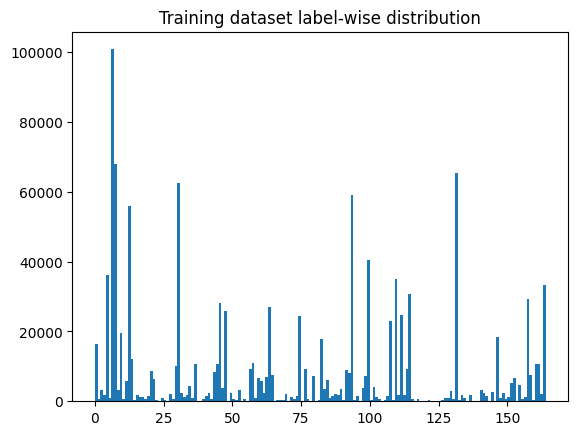

In [4]:
df_train = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RadImgNet_train.csv") ; total_steps = int(len(df_train)//batch_size)
plt.hist(df_train["label"], bins = range(165))
plt.title("Training dataset label-wise distribution")

pp("+="*50)
pp(f"Total Training case : {len(df_train)}")
pp("                                     LABELS")
df_label = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RadImgNet_label_encoding.csv")
pp(df_label)
pp("+="*50)

for img, lab in train_radimagenet_ds.take(1):
    imgs = img
    labs = lab

In [5]:
if viz:
    for img, lab in train_radimagenet_ds.take(1):
        imgs = img
        labs = lab
    print(keras.ops.max(imgs))
    fig, axes = plt.subplots(4,4, figsize = (15,15))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        ax.imshow(imgs[idx], cmap = "bone")
        lab_ = int(labs[idx])
        name = df_label.loc[df_label.index == lab_, 'name'].values[0]
        ax.set_title(f"{lab_} : {name}")
    plt.show()
    

# Stepwise learning
- Multi stage : SSL(instance level) and classification (Multi task learning) -> WSOL (patch level) -> weakly supervised, or unsupervised segmentation(pixel level)
  
- 추가로 구현해야 하는 Additional layer들은 최소한으로 사용하기
- 모듈은 크게 4가지 작성: ViT module, 그 ViT를 인자로 삼아 training하는 SSL and Classification Trainer, WSOL trainer, Segmentation trainer 모듈
    - 각자의 모듈에 optimizer 및 learning rate 미리 세팅
    - ViT module : input as [batch_size, res, res, 1] shape tensor, output as [representation_vector, encoded_patches, attention_weights]
        - representation vector : [batch_size, embed_dims] shape matrix
        - encoded patches : [batch_sise, n_patches, embed_dims] shape tensor
        - attention_weights = list of attnetion weights, attention weight of n-th MHSA layer : [batch_size, n_heads, n_patches, n_patches] shape stochastic tensor.
    - SSL and classification trainer module : SSL as NNCLR, 두 loss를 결합하여 한 개의 single loss를 반환 (즉, total_loss, ssl_loss, classification_loss, classification_accuracy 반환)
    - WSOL : label과 encoded_patches 등을 이용해서 진행. 
    - segmentation : pixel level learning, pixel level annotation은 없음. U-Net이나 그 유사 구조를 활용할 경우, learnable weight를 최소화할 것.

# Stage 0: preparing with helper functions

In [6]:
# 2D RoPE, Fourier block, self attention blocks - helper function for (fourier) ViT

class RoPE2D_KerasNLP(keras.layers.Layer):
    """
    2D Rotary Position Embedding using keras_nlp
    
    keras_nlp.layers.RotaryEmbedding을 2D vision에 확장
    """
    def __init__(self, 
                 embed_dims: int,
                 max_wavelength: int = 10000,
                 scaling_factor: float = 1.0,
                 **kwargs):
        super().__init__(**kwargs)
        
        assert embed_dims % 4 == 0, "embed_dims must be divisible by 4"
        
        self.embed_dims = embed_dims
        self.dim_per_axis = embed_dims // 2
        
        # Height용 RoPE (첫 번째 절반 dimensions)
        self.rope_height = keras_nlp.layers.RotaryEmbedding(
            max_wavelength=max_wavelength,
            scaling_factor=scaling_factor,
            sequence_axis=1,  # Height axis
            feature_axis=-1
        )
        
        # Width용 RoPE (두 번째 절반 dimensions)
        self.rope_width = keras_nlp.layers.RotaryEmbedding(
            max_wavelength=max_wavelength,
            scaling_factor=scaling_factor,
            sequence_axis=2,  # Width axis
            feature_axis=-1
        )
    
    def call(self, x, spatial_shape):
        """
        Args:
            x: [batch, num_patches, embed_dims]
            spatial_shape: (height, width) in patches
        
        Returns:
            x_rope: [batch, num_patches, embed_dims] with RoPE applied
        """
        batch_size = ops.shape(x)[0]
        height, width = spatial_shape
        
        # Reshape to 2D spatial layout
        x_2d = ops.reshape(x, [batch_size, height, width, self.embed_dims])
        
        # Split features: first half for height, second half for width
        x_h = x_2d[..., :self.dim_per_axis]
        x_w = x_2d[..., self.dim_per_axis:]
        
        # Apply RoPE separately
        x_h_rope = self.rope_height(x_h)
        x_w_rope = self.rope_width(x_w)
        
        # Concatenate
        x_rope_2d = ops.concatenate([x_h_rope, x_w_rope], axis=-1)
        
        # Reshape back
        x_rope = ops.reshape(x_rope_2d, [batch_size, height * width, self.embed_dims])
        
        return x_rope
class RoPEMultiHeadAttention(layers.MultiHeadAttention):
    """
    Keras MHA를 상속받아 RoPE를 Q, K에 주입하는 레이어.
    FlashAttention 등 Keras의 최적화를 그대로 활용.
    """
    def __init__(self, rope_2d: RoPE2D_KerasNLP, **kwargs):
        super().__init__(**kwargs)
        self.rope_2d = rope_2d

    def call(self,
             query,
             value,
             key=None,
             spatial_shape=None,  # RoPE를 위한 추가 인자
             attention_mask=None,
             return_attention_scores=False,
             training=False):
        
        if spatial_shape is None:
            raise ValueError("RoPEMultiHeadAttention을 호출할 때는 'spatial_shape' 인자가 반드시 필요합니다.")

        # Self-Attention을 위한 기본 로직
        if key is None:
            key = value

        # --- RoPE 적용을 위한 핵심 수정 ---
        
        # 1. 부모 클래스(MHA)의 Dense 레이어로 Q, K, V를 프로젝션
        q_proj = self._query_dense(query)
        k_proj = self._key_dense(key) 
        v_proj = self._value_dense(value)

        # 2. CLS 토큰과 Patch 토큰 분리
        # (CLS 토큰은 RoPE를 적용하지 않음)
        q_cls, q_patch = q_proj[:, :1, :], q_proj[:, 1:, :]
        k_cls, k_patch = k_proj[:, :1, :], k_proj[:, 1:, :]
        batch_, n_patch_, n_heads_, dims_ = ops.shape(q_patch)
        
        # 3. 프로젝션된 Q, K의 Patch 부분에 2D RoPE 적용
        q_patch_rope = self.rope_2d(ops.reshape(q_patch, [batch_, n_patch_, n_heads_*dims_]), 
                                    spatial_shape=spatial_shape)
        k_patch_rope = self.rope_2d(ops.reshape(k_patch, [batch_, n_patch_, n_heads_*dims_]), 
                                    spatial_shape=spatial_shape)
        q_patch_rope = ops.reshape(q_patch_rope, [batch_, n_patch_, n_heads_, dims_])
        k_patch_rope = ops.reshape(k_patch_rope, [batch_, n_patch_, n_heads_, dims_])
        # 4. CLS 토큰과 RoPE 적용된 Patch 재결합
        q_final = ops.concatenate([q_cls, q_patch_rope], axis=1)
        k_final = ops.concatenate([k_cls, k_patch_rope], axis=1)
        # V는 RoPE가 적용되지 않은 'v_proj'를 그대로 사용
        
        # --- Keras MHA의 나머지 로직 재사용 ---
        
        # 5. 최적화된 어텐션 연산 (부모 클래스의 핵심 메서드)
        attn_output, attn_scores = self._compute_attention(
            q_final,
            k_final,
            v_proj,
            attention_mask=attention_mask,
            training=training,
        )
        
        # 6. Head 결합 및 출력 프로젝션 (부모 클래스의 내부 메서드)
        attn_output = self._output_dense(attn_output)
        # 8. 결과 반환
        if return_attention_scores:
            return attn_output, attn_scores
        return attn_output

# --- 3. Fourier Block (API 시그니처 수정) ---
class FourierTransformBlock(keras.layers.Layer):
    """
    Fourier Transform Block for Token Mixing
    """
    def __init__(self, 
                 embed_dims: int,
                 mlp_ratio: int = 4,
                 dropout_rate: float = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.embed_dims = embed_dims
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential([
            layers.Dense(embed_dims * mlp_ratio, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dims),
        ])
        self.spatial_mlp = keras.Sequential([
            layers.Dense(embed_dims * mlp_ratio, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dims),
        ])
        
    def call(self, inputs, spatial_shape=None, training=False):
        """
        spatial_shape는 API 호환성을 위해 받지만 사용하지 않습니다.
        """
        real_part = inputs
        real_part_fft, im_part_fft = keras.ops.fft((real_part, keras.ops.zeros_like(real_part)))
        
        # Real Part
        real_part_fft = self.norm1(real_part_fft)
        real_part_fft_ffn = self.mlp(real_part_fft, training=training)
        real_part_fft = real_part_fft + real_part_fft_ffn
        real_part_fft = self.norm2(real_part_fft)
        
        # Imaginary part
        im_part_fft = self.norm1(im_part_fft)
        im_part_fft_ffn = self.mlp(im_part_fft, training=training)
        im_part_fft = im_part_fft + im_part_fft_ffn
        im_part_fft = self.norm2(im_part_fft)
        
        x = keras.ops.irfft((real_part_fft, im_part_fft))
        return self.spatial_mlp(x, training=training)

# --- 4. Self Attention Block (RoPEMultiHeadAttention 사용하도록 수정) ---
class SelfAttentionBlock(keras.layers.Layer):
    """
    RoPEMultiHeadAttention을 사용하는 ViT Self-Attention Block
    """
    def __init__(self,
                 num_heads: int,
                 embed_dims: int,
                 rope_2d: RoPE2D_KerasNLP,  # RoPE 레이어 주입
                 mlp_ratio: int = 4,
                 dropout_rate: float = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.num_heads = num_heads
        self.embed_dims = embed_dims
        
        # Layer Normalization
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # (MODIFIED) Keras MHA 대신 RoPEMultiHeadAttention 사용
        self.mhsa = RoPEMultiHeadAttention(
            rope_2d=rope_2d,
            num_heads=num_heads,
            key_dim=embed_dims // num_heads,
            dropout=dropout_rate
        )
        
        # MLP
        self.mlp = keras.Sequential([
            layers.Dense(embed_dims * mlp_ratio, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dims),
            layers.Dropout(dropout_rate)
        ])
    
    def call(self, x, spatial_shape, training=False):
        """
        Args:
            x: [batch, num_patches+1, embed_dims] (with CLS token)
            spatial_shape: (height, width) RoPE 적용에 필요
        """
        # Multi-Head Self-Attention
        x_norm = self.norm1(x)
        
        # (MODIFIED) spatial_shape를 RoPEMultiHeadAttention에 전달
        attn_output, attn_weights = self.mhsa(
            query=x_norm,
            value=x_norm,
            key=x_norm, # Self-attention
            spatial_shape=spatial_shape,
            return_attention_scores=True,
            training=training
        )
        x = x + attn_output
        
        # MLP
        x_norm = self.norm2(x)
        mlp_output = self.mlp(x_norm, training=training)
        x = x + mlp_output
        
        return x, attn_weights

# --- 5. Interleaved Block (API 시그니처 수정 및 CLS 토큰 처리 수정) ---
class InterleavedAttentionBlock(keras.layers.Layer):
    def __init__(self, 
                 embed_dims: int,
                 num_heads: int = 8, 
                 mlp_ratio: int = 4,
                 dropout_rate: float = 0.1,
                 fourier_first = True,
                 rope_2d = None, # RoPE 레이어 주입
                 **kwargs):
        super().__init__(**kwargs)
        self.embed_dims = embed_dims
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.dropout_rate = dropout_rate
        self.fourier_first = fourier_first
        
        self.mhsa_block = SelfAttentionBlock(num_heads, embed_dims, rope_2d, mlp_ratio, dropout_rate)
        self.fourier_block = FourierTransformBlock(embed_dims, mlp_ratio, dropout_rate)
        
    def call(self, x, spatial_shape, training=False):
        """
        Fourier Block가 CLS 토큰을 처리하지 않도록 수정
        """
        cls_token, patches = x[:, :1, :], x[:, 1:, :] # CLS와 Patch 분리
        
        if self.fourier_first:
            patches = self.fourier_block(patches, spatial_shape = spatial_shape, training=training)
            x = ops.concatenate([cls_token, patches], axis=1) # 재결합
            x, attn_weights = self.mhsa_block(x, spatial_shape = spatial_shape, training=training)
        else:
            x, attn_weights = self.mhsa_block(x, spatial_shape = spatial_shape, training=training)
            
            cls_token, patches = x[:, :1, :], x[:, 1:, :] # MHSA 후 다시 분리
            patches = self.fourier_block(patches, spatial_shape = spatial_shape, training=training)
            x = ops.concatenate([cls_token, patches], axis=1) # 재결합
            
        return x, attn_weights

In [7]:
# visualize_token_attention_map ; helper for attention weight viz
def visualize_token_attention_map(vit, image):
    res = ops.shape(image)[-2]
    cls_token, encoded_patches, att_wt_list = vit(image)
    last_attention_weight = att_wt_list[-1]
    batch_size, n_heads, L, _ = tf.shape(last_attention_weight) ; n_patches = L-1
    patch_size = ops.cast(ops.sqrt(ops.cast(n_patches, "float32")),
                         "int32")
    head_colors = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys', 'YlOrBr', 'YlGnBu']
    cls_att = last_attention_weight[:,:, 0, 1:] #batch, n_heads, n_patches
    for b in range(batch_size):
        fig, axes = plt.subplots(1, 3, figsize = (20,6))
        
        axes = axes.flatten()
        axes[0].set_title(f"original image {b+1}")
        axes[0].imshow(image[b], cmap = "bone")
        axes[1].set_title("All head W, quantized")
        axes[2].set_title(f"overlay image {b+1}")
        axes[2].imshow(image[b], cmap = "bone", alpha = 0.6)
        #head merge
        for h in range(n_heads):
            att_map = cls_att[b, h]
            att_map = ops.reshape(att_map, [patch_size, patch_size])
            att_map = (att_map-ops.min(att_map)) / (ops.max(att_map) - ops.min(att_map) + 1e-5)
            att_map_bin = ops.cast(att_map > ops.mean(att_map),
                              "int32")
            att_map *= 255
            att_map_bin *= 255
            
            att_map = ops.cast(att_map, "uint8")
            upsampled_map = tf.image.resize(att_map[None, ..., None], [res,res])[0,:,:,0]
            upsampled_map = ops.cast(upsampled_map, "uint8")
            axes[1].imshow(att_map_bin, cmap=head_colors[h % len(head_colors)], alpha=0.6)
            axes[2].imshow(upsampled_map, cmap=head_colors[h % len(head_colors)], alpha=0.5)
    plt.tight_layout()
    plt.show()
    flatten_w = ops.reshape(cls_att, [-1,])
    plt.hist(flatten_w, density = True, histtype = "stepfilled", bins = 100)
    plt.title("CLS Attention Weight (last layer) Distribution")
    plt.show()

In [8]:
# --- 6. MedicalViT (RoPE 적용 로직 수정) ---
class MedicalViT(keras.Model):
    """
    Fourier Vision Transformer with Flexible Resolution
    RoPE가 어텐션 블록 내부의 Q, K에만 적용되도록 수정됨.
    """
    def __init__(self,
                 patch_size,
                 conv_base = None,
                 interleaved = False, num_interleaved_layers = 6, fourier_first = True,
                 num_fourier_layers: int = 8,  # N개의 Fourier blocks
                 num_attention_layers: int = 4,
                 num_heads: int = 6,
                 embed_dims: int = 384,
                 mlp_ratio: int = 2,
                 dropout_rate: float = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.patch_size = patch_size
        self.conv_base = conv_base
        self.num_fourier_layers = num_fourier_layers
        self.num_attention_layers = num_attention_layers
        self.embed_dims = embed_dims
        self.interleaved = interleaved
        self.num_interleaved_layers = num_interleaved_layers
        self.fourier_first = fourier_first
        
        # Patch Embedding
        self.patch_embed = layers.Conv2D(embed_dims, 
                                         kernel_size=patch_size, 
                                         strides=patch_size, 
                                         padding='valid', activation = "gelu"
                                        )
        if self.conv_base:
            self.conv_base.trainable = True
            self.patch_embed = layers.Dense(units = embed_dims, activation = 'gelu', name = "EmbedAfterConv")
        # CLS Token
        self.cls_token = self.add_weight(
            shape=(1, 1, embed_dims),
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            name='cls_token'
        )
        
        # 2D RoPE (인스턴스 생성)
        self.rope_2d = RoPE2D_KerasNLP(
            embed_dims=embed_dims,
            max_wavelength=10000,
            scaling_factor=1.0
        )
        
        # Fourier Transform Blocks (N layers)
        self.fourier_blocks = []
        for i in range(self.num_fourier_layers):
            self.fourier_blocks.append(
                FourierTransformBlock(
                    embed_dims=embed_dims,
                    mlp_ratio=mlp_ratio,
                    dropout_rate=dropout_rate,
                    name=f'fourier_block_{i}'
                )
            )
        
        # Self-Attention Block (RoPE 주입)
        self.mhsa_blocks = []
        for i in range(self.num_attention_layers):
            self.mhsa_blocks.append(SelfAttentionBlock(
                num_heads=num_heads,
                embed_dims=embed_dims,
                rope_2d=self.rope_2d,  # RoPE 레이어 전달
                mlp_ratio=mlp_ratio,
                dropout_rate=dropout_rate,
                name=f'attention_block_{i}'
            ))
            
        if self.interleaved : 
            self.interleaved_blocks = []
            for i in range(self.num_interleaved_layers):
                self.interleaved_blocks.append(InterleavedAttentionBlock(
                    embed_dims = embed_dims,
                    num_heads = num_heads,
                    mlp_ratio = mlp_ratio,
                    dropout_rate = dropout_rate,
                    fourier_first = self.fourier_first,
                    rope_2d=self.rope_2d  # RoPE 레이어 전달
                  )
                )
        
        # Final Normalization
        self.norm = layers.LayerNormalization(epsilon=1e-6, name='final_norm')

    def call(self, inputs, training=False):
        """
        Forward pass - RoPE가 `x`에서 제거되고 블록 내부로 이동
        """
        batch_size = ops.shape(inputs)[0]
        input_height = ops.shape(inputs)[1]
        input_width = ops.shape(inputs)[2]
        
        # Compute spatial dimensions
        patch_height = input_height // self.patch_size
        patch_width = input_width // self.patch_size
        num_patches = patch_height * patch_width
        spatial_shape = (patch_height, patch_width)
        
        # 1. Patch Embedding (순수 시맨틱)
        if self.conv_base:
            x = self.conv_base(inputs/255)
            x = self.patch_embed(x)
            batch_size, patch_height, patch_width, d_ = ops.shape(x)
            num_patches = patch_height * patch_width
            spatial_shape = (patch_height, patch_width)
        else:
            x = self.patch_embed(inputs/255)  # [batch, h//p, w//p, embed_dims]
        x = ops.reshape(x, [batch_size, num_patches, self.embed_dims])
        
        # --- XX RoPE 적용 제거 (가장 큰 수정) XX ---
        # x = self.rope_2d(x, spatial_shape=spatial_shape)
        
        cls_tokens = ops.repeat(self.cls_token, batch_size, axis=0)
        attention_weights = []
        
        if self.interleaved:
            x = ops.concatenate([cls_tokens, x], axis=1)
            for interleaved_attention in self.interleaved_blocks:
                # spatial_shape와 training 전달
                x, att_wt = interleaved_attention(x, spatial_shape=spatial_shape, training=training)
                attention_weights.append(att_wt)
        else:
            # 3. Fourier Transform Blocks (CLS 토큰 없이)
            # spatial_shape와 training 전달
            for fourier_block in self.fourier_blocks:
                # (Fourier는 CLS 토큰을 처리하지 않음)
                x = fourier_block(x, spatial_shape=spatial_shape, training=training)
            
            # 4. Add CLS token
            x = ops.concatenate([cls_tokens, x], axis=1)
            
            # 5. Self-Attention Block
            # spatial_shape와 training 전달
            for mhsa_block in self.mhsa_blocks:
                x, att_wt = mhsa_block(x, spatial_shape=spatial_shape, training=training)
                attention_weights.append(att_wt)
        
        # 6. Final Normalization
        x = self.norm(x)
        
        # 7. Extract outputs
        feature_vector = x[:, 0, :]  # CLS token [batch, embed_dims]
        encoded_patches = x[:, 1:, :]  # Patches [batch, num_patches, embed_dims]
        
        return feature_vector, encoded_patches, attention_weights

> Unsupervised image segmentation?

- pretrained ViT를 vit, input medical images를 img라 하자. vit(img)는 [cls_token, encoded_patches, ]야. 목적은 encoded_patches에서 unsupervised semantic segmentation을 수행하는 것임. 

- encoded_patches shape을 [batch_size, n_patches, embed_dims]라 하자. encoded_patch에 cluster function C를 가해 agglomerative clustering, k-means clustering 혹은 learnable parameter를 사용하여 각 patch가 1, 2, ..., K 개의 category 중 한 개에 속하도록 만들 거야.
즉 cluster_patches = C(encoded_patches) 는 [batch_size, n_patches] shape tensor고 각 원소는 1, 2, ..., K 중 한 개의 원소야. clustering 시 cosine similarity를 distance로 활용함.
cluster_patches의 예시는 [[1,2,10,9,4,2,4,1,...], [2,3,7,9,10,1,12,...], ...]야. 이 discrete한 tensor를  확률분포로 변환할 건데 (변환 함수를 f_d라 하자)
cluster_proba = f_d(cluster_patches)는 category 1, 2, 3, ..., K 각각의 확률질량값을 나타내. 즉  [P(category=1), P(category=2), ...]야. 이 다음, 가장 P 값이 높은 것부터 sort하여 결과값을 반환해 : [0.7, 0.08, 0.05, 0.01, ....]
cluster_proba shape은 [batch_size, n_patches]야. keras.ops.sum(cluster_integer, axis = 1)은 [batch_size,] shape인 1로 이루어진 벡터야.

- unsupervised segmentation loss는 cluster integer matrix에서 작동하는데, 이미지의 패치들이 1)한 카테고리에만 배정(collapse)되어서도 안 되고, 2)K개의 카테고리에 아무렇게나(즉 너무 uniform하게) 배치되어도 안 돼 (trivial solution).
1을 위해서 KL_divergence(uniform 분포, cluster_proba)를 최소화하고, 2를 위해서 KL_divergence(target_dist, cluster_proba)를 최소화한다.
이 때 target_dist는 a) 감마 분포, b) 표준정규분포(단, x>0로 제한) 등을 생각할 수 있다 (배경이 가장 많고, 그 다음은 category A, 그 다음은 Category B, ...)
target_dist를 특정 분포에서 Sampling하여 KL divergence를 구할 수 있어야 한다

power


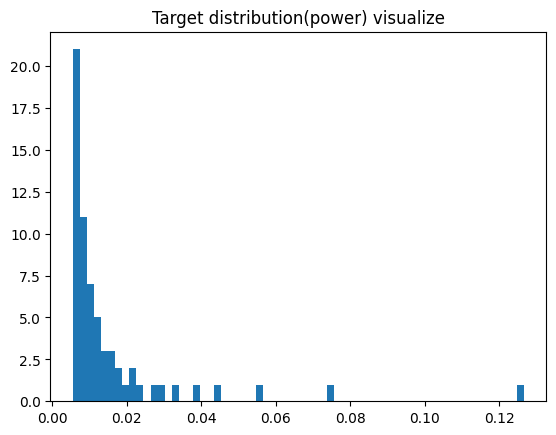

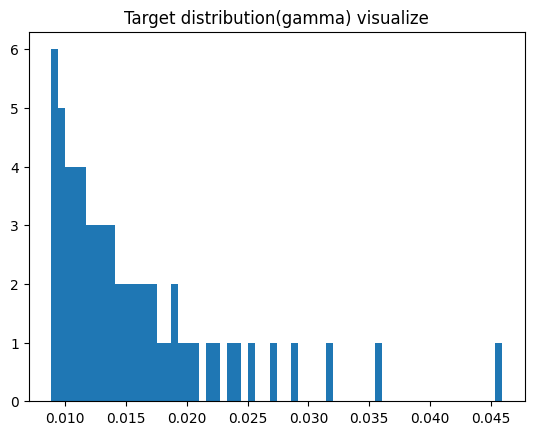

In [9]:
def create_target_distribution(k, method='gamma'): # 기본값을 gamma로 변경
    """
    정렬된 목표 분포(target_dist)를 생성합니다.
    """
    if method == 'gamma':
        # Gamma(concentration < 1)는 0 근처에서 PDF가 가장 높음
        lin = ops.linspace(0.1, 10.0, k) # 0을 피하기 위해 0.1에서 시작
        dist = tfp.distributions.Gamma(concentration=0.75, rate=0.05) # concentration < 1
        target_unnormalized = dist.prob(lin)
        
    elif method == "trunc_normal": # trunc_normal
        # 0에서 감소하는 분포를 위해 loc=low
        lin = ops.linspace(0.0, 3.0, k)
        dist = tfp.distributions.TruncatedNormal(loc=0.0, scale=1.0, low=0.0, high=3.0) # high를 3.0으로 명시
        target_unnormalized = dist.prob(lin)
    elif method in ['zip', 'power', 'zipfian']:
        print(method)
        indices = ops.arange(k, dtype="float32") + 1.0
        target_unnormalized = 1.0 / ops.power(indices, 0.75)
        return target_unnormalized / ops.sum(target_unnormalized)
    # 요청대로 가장 P값이 높은 것부터 정렬
    target_sorted = ops.sort(target_unnormalized)[::-1]
    
    # 확률분포로 정규화
    target_dist = target_sorted / ops.sum(target_sorted)
    return target_dist
dist = create_target_distribution(k = 64, method = 'power')
plt.hist(dist, bins = 64)
plt.title("Target distribution(power) visualize")
plt.show()

dist = create_target_distribution(k = 64, method = 'gamma')
plt.hist(dist, bins = 64)
plt.title("Target distribution(gamma) visualize")
plt.show()



# How to make Encoded patches to K-categorical probability?

- K-means 혹은 agglomerative clustering 진행; 이 clustering 연산을 f_d라고 하고, 코드에서는 ClusteringLayer로 구현함
- cluster 결과 각 batch내 patch들이 K개 카테고리에 속할 확률을 알 수 있음 -> (Batch_size, n_patches, K) shape
- 위 과정을 미분가능하게 만들어주는 것이 STEProbabilityLayer;
> STE layer?
 
- STEProbabilityLayer는 **순전파(Forward Pass)**와 역전파(Backward Pass) 때 서로 다른 계산을 하도록 "속임수(trick)"를 씁니다.
- 이 레이어는 patch_proba_soft ([B, N, K])를 입력으로 받습니다.
    - A. 순전파 (Forward Pass): "이산적인 결정":
    - 순전파 시에는 우리가 원하는 대로 이산적인 argmax 결과를 사용합니다. cluster_patches_indices = ops.argmax(patch_proba_soft, axis=-1) 을 통해 "Soft" 확률([0.9, 0.1])을 "Hard" 결정(0)으로 바꿉니다;
        - 출력 1: cluster_patches ([B, N]): 이산적인 인덱스 맵 (시각화 등에 사용 가능).
          - one_hot_hard = tf.one_hot(cluster_patches_indices, ...) : 0을 [1, 0, 0, ...] 과 같은 one-hot 벡터로 만듭니다. (shape [B, N, K])

    - B. 마법의 STE 공식 (순전파 + 역전파)

> one_hot_ste = tf.stop_gradient(one_hot_hard - patch_proba_soft) + patch_proba_soft

    순전파: tf.stop_gradient는 순전파 시 아무것도 안 합니다.

    - (one_hot_hard - patch_proba_soft) + patch_proba_soft
    - patch_proba_soft가 소거되어 결국 one_hot_hard만 남습니다.

> 결론: 순전파 시에는 one_hot_hard ([B, N, K])가 사용됩니다.

    - 역전파: tf.stop_gradient는 괄호 안의 모든 연산에 대한 그래디언트(기울기)를 강제로 0으로 만듭니다.
    - 그래디언트 관점에서 tf.stop_gradient(...) 부분은 "상수(constant)" 취급됩니다. (기울기 0)
    - 오직 + patch_proba_soft 부분만 그래디언트가 살아남아 뒤로 전달됩니다.
    - 결론: 역전파 시에는 patch_proba_soft의 그래디언트가 사용됩니다.

In [10]:
class STEProbabilityLayer(keras.layers.Layer):
    """Soft-assignment([B, N, K]) -> cluster_proba([B, K]), cluster_patches([B, N])"""
    def __init__(self, k, **kwargs):
        super().__init__(**kwargs)
        self.k = k

    def call(self, patch_proba_soft):
        # patch_proba_soft shape: [B, N, K]
        
        # 순전파용 Hard assignment
        cluster_patches_indices = ops.argmax(patch_proba_soft, axis=-1) # [B, N]
        one_hot_hard = tf.one_hot(cluster_patches_indices, depth=self.k, dtype=tf.float32)

        # STE: 순전파(hard)와 역전파(soft) 분리
        one_hot_ste = tf.stop_gradient(one_hot_hard - patch_proba_soft) + patch_proba_soft

        # f_d: cluster_proba 계산
        cluster_counts_ste = ops.sum(one_hot_ste, axis=1) # [B, K]
        n_patches = ops.shape(patch_proba_soft)[1]
        cluster_proba = cluster_counts_ste / ops.cast(n_patches, dtype=tf.float32)

        return cluster_proba, cluster_patches_indices, patch_proba_soft

In [11]:
class ClusteringLayer(keras.layers.Layer):
    def __init__(self, k, n_iterations=3, temperature=0.07, method='soft_kmeans',
                 spatial_scale: float = 0.1, # 좌표의 중요도 조절
                 distance_metric: str = 'l2', # (NEW) 거리 척도 선택 ('cosine' or 'l2')
                 **kwargs):
        super().__init__(**kwargs)
        if method not in ['soft_kmeans', 'soft_agglomerative', 'kmeans', 'agglomerative']:
            raise ValueError("지원되지 않는 method입니다.")
        if distance_metric not in ['cosine', 'cos_sim', 'cos',
                                   'l2', 'L2', 'euclidian']: # (NEW) 거리 척도 검증
             raise ValueError("distance_metric은 'cosine', 'cos_sim', 'cos', 'l2', 'L2', 또는 'euclidian'여야 합니다.")
            
        self.k = k
        self.n_iterations = n_iterations
        self.temperature = temperature
        self.method = method
        self.spatial_scale = spatial_scale
        self.distance_metric = distance_metric # (NEW)
        self.ste_layer = STEProbabilityLayer(self.k)
        
    def build(self, input_shape):
        super().build(input_shape)

    # --- 좌표 관련 헬퍼 (변경 없음) ---
    def _create_coordinate_grid(self, batch_size, spatial_shape):
        height, width = spatial_shape
        y_coords = ops.linspace(-1.0, 1.0, height)
        x_coords = ops.linspace(-1.0, 1.0, width)
        y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
        coords_2d = ops.stack([y_grid, x_grid], axis=-1)
        coords_1d = ops.reshape(coords_2d, (height * width, 2))
        coords_1d_expanded = ops.expand_dims(coords_1d, axis=0)
        return ops.repeat(coords_1d_expanded, batch_size, axis=0)

    def _prepare_spatial_features(self, encoded_patches, spatial_shape):
        batch_size = ops.shape(encoded_patches)[0]
        # 시맨틱 특징 정규화 (코사인 유사도 사용 시 중요)
        # L2 사용 시에는 정규화하지 않는 것이 벡터 크기 정보를 보존하는 데 유리할 수 있음
        # 여기서는 우선 정규화 유지 (사용자가 필요시 수정 가능)
        if self.distance_metric in ['cosine', 'cos_sim', 'cos']:
            patches_norm = ops.normalize(encoded_patches, axis=-1)
        else:
            patches_norm = encoded_patches
        coords = self._create_coordinate_grid(batch_size, spatial_shape = spatial_shape)
        coords_scaled = coords * self.spatial_scale
        features_with_coords = ops.concatenate([patches_norm, coords_scaled], axis=-1)
        return features_with_coords

    # --- 거리/유사도 계산 헬퍼 ---
    def _cosine_similarity(self, x, y, normalize=True):
        """ 코사인 유사도 계산 (ops.normalize 내장) """
        # x: [B, N, D+2], y: [K, D+2] or [B, N, D+2] or [B, K, D+2]
        if normalize:
            x_norm = ops.normalize(x, axis=-1)
            y_norm = ops.normalize(y, axis=-1)
        else: # 이미 정규화된 경우
             x_norm = x
             y_norm = y

        # y의 형태에 따라 einsum 경로 분기
        if len(ops.shape(y)) == 2: # [K, D+2] (K-means 센터)
            sim = ops.einsum('bnd,kd->bnk', x_norm, y_norm)
        elif len(ops.shape(y)) == 3 and ops.shape(x)[1] == ops.shape(y)[1]: # [B, N, D+2] (Agglo 패치-패치)
             y_transposed = ops.transpose(y_norm, (0, 2, 1))
             sim = ops.einsum('bnd,bdn->bnn', x_norm, y_transposed) # [B, N, N]
        elif len(ops.shape(y)) == 3 and ops.shape(y)[1] == self.k: # [B, K, D+2] (Agglo 초기 센터)
             y_transposed = ops.transpose(y_norm, (0, 2, 1))
             sim = ops.einsum('bnd,bdk->bnk', x_norm, y_transposed) # [B, N, K]
        else:
             raise ValueError(f"지원되지 않는 y shape: {ops.shape(y)}")
        return sim

    def _euclidean_distance_squared(self, x, y):
        """ 제곱 유클리드 거리 계산 """
        # x: [B, N, D+2], y: [K, D+2] or [B, N, D+2] or [B, K, D+2]
        x_sq = ops.sum(ops.square(x), axis=-1, keepdims=True) # [B, N, 1]

        # y의 형태에 따라 계산 분기
        if len(ops.shape(y)) == 2: # [K, D+2] (K-means 센터)
            y_sq = ops.sum(ops.square(y), axis=-1, keepdims=True) # [K, 1]
            y_sq_transposed = ops.transpose(y_sq, (1, 0)) # [1, K]
            xy = ops.einsum('bnd,kd->bnk', x, y)
            dist_sq = x_sq - 2 * xy + y_sq_transposed # [B, N, K]
        elif len(ops.shape(y)) == 3 and ops.shape(x)[1] == ops.shape(y)[1]: # [B, N, D+2] (Agglo 패치-패치)
             y_sq = ops.sum(ops.square(y), axis=-1, keepdims=True) # [B, N, 1]
             y_sq_transposed = ops.transpose(y_sq, (0, 2, 1)) # [B, 1, N]
             xy = ops.einsum('bnd,bmd->bnm', x, y) # [B, N, N]
             dist_sq = x_sq - 2 * xy + y_sq_transposed # [B, N, N]
        elif len(ops.shape(y)) == 3 and ops.shape(y)[1] == self.k: # [B, K, D+2] (Agglo 초기 센터)
             y_sq = ops.sum(ops.square(y), axis=-1, keepdims=True) # [B, K, 1]
             y_sq_transposed = ops.transpose(y_sq, (0, 2, 1)) # [B, 1, K]
             xy = ops.einsum('bnd,bkd->bnk', x, y) # [B, N, K]
             dist_sq = x_sq - 2 * xy + y_sq_transposed # [B, N, K]
        else:
             raise ValueError(f"지원되지 않는 y shape: {ops.shape(y)}")

        return ops.maximum(dist_sq, 0.0) # 수치적 안정성

    # --- 클러스터링 로직 ---
    def _soft_kmeans(self, spatial_features):
        b, n, d_plus_2 = ops.shape(spatial_features)
        patches_flat = ops.reshape(spatial_features, (b * n, d_plus_2))
        indices = tf.random.shuffle(tf.range(b * n))[:self.k]
        centers = tf.gather(patches_flat, indices) # [K, D+2]

        patch_proba_soft = None
        for _ in range(self.n_iterations):
            # [E-Step] 유사도 또는 거리 계산
            if self.distance_metric in ['cosine', 'cos', 'cos_sim']:
                # 코사인 유사도는 클수록 좋음
                sim = self._cosine_similarity(spatial_features, centers) # [B, N, K]
                patch_proba_soft = ops.softmax(sim / self.temperature, axis=-1)
            else: # 'l2'
                # L2 거리는 작을수록 좋음 (음수 취함)
                dist_sq = self._euclidean_distance_squared(spatial_features, centers) # [B, N, K]
                patch_proba_soft = ops.softmax(-dist_sq / self.temperature, axis=-1)

            # [M-Step] 센터 업데이트 (동일)
            R_sum = ops.transpose(ops.sum(patch_proba_soft, axis=1, keepdims=True), (0, 2, 1))
            R_T = ops.transpose(patch_proba_soft, (0, 2, 1))
            weighted_sum = ops.einsum('bkn,bnd->bkd', R_T, spatial_features)
            centers_batch = weighted_sum / (R_sum + 1e-6)
            centers = ops.mean(centers_batch, axis=0) # [K, D+2]
        return patch_proba_soft

    def _soft_agglomerative(self, spatial_features):
        b, n, d_plus_2 = ops.shape(spatial_features)
        
        # 1. 유사도/거리 그래프(W) 생성
        if self.distance_metric  in ['cosine', 'cos', 'cos_sim']:
            W_sim = self._cosine_similarity(spatial_features, spatial_features) # [B, N, N]
            W = ops.softmax(W_sim / self.temperature, axis=-1)
        else: # 'l2'
            W_dist_sq = self._euclidean_distance_squared(spatial_features, spatial_features) # [B, N, N]
            W = ops.softmax(-W_dist_sq / self.temperature, axis=-1)

        # 2. 초기 확률(P_t) 생성
        indices = tf.random.shuffle(tf.range(n))[:self.k]
        centers_0 = tf.gather(spatial_features, indices, axis=1) # [B, K, D+2]
        
        if self.distance_metric in ['cosine', 'cos', 'cos_sim']:
            sim_0 = self._cosine_similarity(spatial_features, centers_0) # [B, N, K]
            P_t = ops.softmax(sim_0 / self.temperature, axis=-1)
        else: # 'l2'
            dist_0_sq = self._euclidean_distance_squared(spatial_features, centers_0) # [B, N, K]
            P_t = ops.softmax(-dist_0_sq / self.temperature, axis=-1)

        # 3. 확산 반복 (동일)
        for _ in range(self.n_iterations):
            P_logits = ops.einsum('bnj,bjk->bnk', W, P_t)
            P_t = ops.softmax(P_logits / (self.temperature * 0.5), axis=-1)
        return P_t

    # --- call 메서드 (변경 없음) ---
    def call(self, encoded_patches, spatial_shape):
        spatial_features = self._prepare_spatial_features(encoded_patches, spatial_shape)
        
        if self.method == 'soft_kmeans' or self.method == 'kmeans':
            patch_proba_soft = self._soft_kmeans(spatial_features)
        elif self.method == 'soft_agglomerative' or self.method == 'agglomerative':
            patch_proba_soft = self._soft_agglomerative(spatial_features)
        else:
            raise ValueError(f"'{self.method}'는 지원되지 않는 method입니다.")
            
        cluster_proba, cluster_patches, patch_proba_soft = self.ste_layer(patch_proba_soft)
        
        return cluster_proba, cluster_patches, patch_proba_soft

> Learnable clustering layer

- Cluster Prototype [K, embed_dims] shape tensor, learnable, EMA update
    - K개 클러스터의 embed space에서의 대표 벡터를 지정
    - encoded patches와 distance 측정하여 clustering
    - 1 step 후 EMA로 update
- cluster layer에 loss function 넣고,
    - clustering loss, 각 entropy 반환하여 모니터링

In [12]:
class LearnableClusteringLayer(keras.layers.Layer):
    def __init__(self, k, embed_dims = embed_dims,
                 temperature=0.07,
                 distance_metric: str = 'l2', # (NEW) 거리 척도 선택 ('cosine' or 'l2' or 'dot')
                 **kwargs):
        super().__init__(**kwargs)
        if distance_metric not in ['cosine', 'cos_sim', 'cos', #<- Cosine similarity
                                   'l2', 'L2', 'euclidean',#<- Euclidean distance
                                  "dot"]: 
             raise ValueError("distance_metric은 'cosine', 'cos_sim', 'cos', 'l2', 'L2', 'euclidean' 또는 'dot' 여야 합니다.")
            
        self.k = k
        self.embed_dims = embed_dims
        self.temperature = temperature
        self.distance_metric = distance_metric # L2 or cosine
        self.cluster_center = self.add_weight(
                                    shape=(k, self.embed_dims),
                                    initializer=keras.initializers.Orthogonal(),
                                    trainable=True,
                                    name='cluster_center'
                                )
    def build(self, input_shape):
        super().build(input_shape)

    # --- 거리/유사도 계산 헬퍼 ---
    def _dot_similarity(self, patches):
        dim = ops.shape(self.cluster_center)[-1]
        sim = ops.einsum("bnd, kd -> bnk", patches, self.cluster_center)
        sim /= ops.sqrt(dim) #scaled dot-product
        return sim
    def _cosine_similarity(self, patches, normalize=True):
        """ 코사인 유사도 계산 (ops.normalize 내장) """
        # x: [B, N, D] shape tensor y: [K,D] shape tensor 
        x = patches
        y = self.cluster_center
        if normalize:
            x_norm = ops.normalize(x, axis=-1)
            y_norm = ops.normalize(y, axis=-1)
        else: # 이미 정규화된 경우
             x_norm = x
             y_norm = y

        sim = ops.einsum("bnd, kd -> bnk", x_norm, y_norm)
        return sim

    def _euclidean_distance_squared(self, patches):
        """ 제곱 유클리드 거리 계산 """
        # x: [B, N, D] shape feature tensor y: [K,D] shape cluster center tensor 
        # after broadcasting : x [B, N, 1, D] // y: [1, 1, K, D]
        x = patches
        y = self.cluster_center
        batch_size, n, _ = ops.shape(x)
        k, _ = ops.shape(y)
        
        x = ops.expand_dims(x, axis = 2)
        y = ops.expand_dims(y, axis = [0,1])
        distance = ops.sum(ops.square(x-y),
                           axis = -1) #[B, N, K]
        assert (batch_size, n, k) == ops.shape(distance), "유클리드 거리 계산 내 에러"
        return distance

    # call 시 mi loss, segment_per_patches, patch proba soft 리턴
    # segment, soft proba는 similarity나 distance의 softmax.
    def compute_mi_loss(self, soft_proba):
        
        soft_proba = ops.clip(soft_proba, 1e-6, 1.0)
        
        batch_size, n_patches, n_clusters = ops.shape(soft_proba)
        p_c = ops.mean(soft_proba, axis = [0,1]) #K length vector
        p_c = p_c/ops.sum(p_c)
        h_c = -ops.sum(p_c*ops.log(p_c))

        entropy_per_patch = -ops.sum(soft_proba * ops.log(soft_proba),
                                     axis = -1) #batch_size, n_patches shape matrix
        h_c_given_x = ops.mean(entropy_per_patch)
        mi = h_c - h_c_given_x
        return -mi, h_c, h_c_given_x
        
    def call(self, encoded_patches):
        if self.distance_metric in ["L2", 'l2', 'euclidian']:
            sim_matrix = self._euclidean_distance_squared(encoded_patches)
        elif self.distance_metric == "dot":
            sim_matrix = self._dot_similarity(encoded_patches) 
        else:
            sim_matrix = self._cosine_similarity(encoded_patches)
        sim_matrix /= self.temperature
        #sim_matrix : [batch_size, N_patches, K]
        patch_proba_soft = ops.softmax(sim_matrix, axis = -1) #[batch_size, N_patches, K] shape stochastic tensor
        cluster_patches = ops.argmax(patch_proba_soft, axis = -1) #[batch_size, N_patches] shape integer matrix
        mi_loss, h_c, h_c_given_x = self.compute_mi_loss(patch_proba_soft)
        return mi_loss, h_c, h_c_given_x, cluster_patches, patch_proba_soft #cluster_patches :[batch_Size, N_patches]

In [13]:
def compute_unsupervised_loss(cluster_proba, target_dist, uniform_dist):
    """ Anti-collapse 및 Anti-trivial Loss 계산 """
    kl_loss_fn = keras.losses.KLDivergence(reduction='none')
    cluster_proba_safe = ops.clip(cluster_proba, 1e-6, 1.0)
    
    # Loss 1 (Anti-collapse): KL(uniform || cluster_proba)
    loss_1 = kl_loss_fn(ops.expand_dims(uniform_dist, 0), cluster_proba_safe)
    
    # Loss 2 (Anti-trivial): KL(target_dist || sorted(cluster_proba))
    cluster_proba_sorted = tf.sort(cluster_proba_safe, axis=-1, direction='DESCENDING')
    loss_2 = kl_loss_fn(ops.expand_dims(target_dist, 0), cluster_proba_sorted)
    
    return ops.mean(loss_1), ops.mean(loss_2)

# ViT setting

In [14]:
import keras
from keras import layers, ops

def mlp_block(x, hidden_dim):
    """Feedforward MLP: expand -> GELU -> project"""
    filters = ops.shape(x)[-1]
    x = layers.Conv2D(hidden_dim, 1, use_bias=True)(x)
    x = layers.Activation("gelu")(x)
    x = layers.Conv2D(filters, 1, use_bias=True)(x)
    return x

def transformer_style_conv_block(x, filters, stride=1, mlp_ratio=4):
    """
    ViT-style block: 
      - Norm -> Conv -> Add (residual)
      - Norm -> MLP  -> Add (residual)
    If stride>1 or filters mismatch, project shortcut.
    """
    shortcut = x
    if stride != 1 or ops.shape(x)[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=True)(shortcut)
    
    # Branch 1: Norm -> Conv -> Residual
    out = layers.LayerNormalization(axis=-1, epsilon=1e-6)(x)
    out = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=True)(out)
    out = layers.Activation("gelu")(out)
    out = layers.Add()([out, shortcut])
    
    # Branch 2: Norm -> MLP -> Residual
    residual = out
    out = layers.LayerNormalization(axis=-1, epsilon=1e-6)(out)
    out = mlp_block(out, hidden_dim=int(filters * mlp_ratio))
    out = layers.Add()([out, residual])
    
    return out

def make_stage(x, filters, num_blocks, downsample, mlp_ratio=4):
    x = transformer_style_conv_block(x, filters, stride=(2 if downsample else 1), mlp_ratio=mlp_ratio)
    for _ in range(num_blocks - 1):
        x = transformer_style_conv_block(x, filters, stride=1, mlp_ratio=mlp_ratio)
    return x

def build_vit_style_conv_encoder(embed_dims: int = 256, blocks_per_stage=(1,1,1,1,1), mlp_ratio=4):
    """
    - Input: uint8 [B, H, W, 1], dynamic H/W.
    - Total downsample: 16× (4 stride=2 stages).
    - Output: [B, n_patch, embed_dims], n_patch=(H/16)*(W/16).
    - Block: ViT-style Norm -> Conv -> Add -> Norm -> MLP -> Add.
    """
    inp = keras.Input(shape=(None, None, 1), dtype="uint8", name = 'UniversalMedImageInput')
    x = layers.Lambda(lambda t: ops.cast(t, "float32") / 255.0)(inp)
    
    # Stem: simple conv + gelu
    x = layers.Conv2D(64, 3, strides=1, padding="same", use_bias=True)(x)
    x = layers.Activation("gelu")(x)
    
    # 4× downsample (16x total), last stage no downsample and outputs embed_dims channels
    filters_plan = [64, 96, 128, 160, embed_dims]
    downsamples  = [True, True, True, True, False]
    
    for f, n, ds in zip(filters_plan, blocks_per_stage, downsamples):
        x = make_stage(x, f, num_blocks=n, downsample=ds, mlp_ratio=mlp_ratio)
    
    # [B, H/16, W/16, embed_dims] -> [B, n_patch, embed_dims]
    patches = keras.layers.Reshape((-1, embed_dims))(x)
    #patches = layers.Lambda(lambda t: ops.reshape(t, (ops.shape(t)[0], ops.shape(t)[1]*ops.shape(t)[2], ops.shape(t)[3])),
    #                        name="patch_embeddings")(x)
    return keras.Model(inp, patches, name="ViTStyleConvEncoder")


In [20]:
conv_stem = build_vit_style_conv_encoder(embed_dims=embed_dims, 
                                         blocks_per_stage=(1,1,1,1,1), 
                                         mlp_ratio=4)
#conv_stem(ops.ones((2, 512, 512, 1), dtype="uint8"))  # 출력: [2, 1024, 256]

In [21]:
hybrid = MedicalViT(conv_base = conv_stem,
                    patch_size = patch_size, embed_dims = embed_dims,
                 num_fourier_layers = n_fourier, num_attention_layers = n_attention,
                 interleaved = interleaved, num_interleaved_layers= 6, 
                     )
vit = MedicalViT(conv_base = None,
                 patch_size = patch_size, embed_dims = embed_dims,
                 num_fourier_layers = n_fourier, num_attention_layers = n_attention,
                 interleaved = interleaved, num_interleaved_layers= 6, 
                     )
hybrid.summary()

Model: "medical_vi_t"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ViTStyleConvEncoder             │ (None, None, 384)      │     2,675,648 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbedAfterConv (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ro_pe2d__keras_nlp              │ ?                      │   0 (unbuilt) │
│ (RoPE2D_KerasNLP)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_block_0               │ ?                      │   0 (unbuilt) │
│ (SelfAttentionBlock)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_block_1               │ ?                      │   0 (unbuilt) │
│ (SelfAttentionBlock)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_norm (LayerNormalization) │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,676,032 (10.21 MB)

 Trainable params: 2,676,032 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

# Output Visualization helpers

In [ ]:
#GradCAM compute
from io import BytesIO
from PIL import Image

class ViTGradCAM:
    """
    GradCAM for Vision Transformer
    - Handles patch-based outputs: [B, N, D]
    - Vectorized for minimal loops
    """
    def __init__(self, model):
        self.model = model
        self.vit = model.student_vit  # Use student for GradCAM
        self.cls_head = model.cls_head
    
    def get_heatmap(self, images, class_indices=None):
        """
        Computes GradCAM heatmaps for a batch of images.
        
        Args:
            images: Tensor of shape [B, H, W, C].
            class_indices: [B] tensor of target class indices. 
                           If None, uses the predicted class for each image.
                           
        Returns:
            heatmaps: [B, H, W] GradCAM heatmaps.
            preds: [B] predicted class indices.
        """
        images = tf.cast(images, tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(images)
            # Get patch embeddings (last layer before global average pooling)
            cls_token, patch_embeddings, _ = self.vit(images, training=False)
            
            # Use CLS token for classification
            logits = self.cls_head(cls_token)
            
            preds = tf.argmax(logits, axis=-1, output_type=tf.int32)
            
            if class_indices is None:
                # If no class specified, use predicted class
                target_indices = preds
            else:
                target_indices = tf.cast(class_indices, tf.int32)
            
            # Get the score for the target class
            batch_size = tf.shape(images)[0]
            gather_indices = tf.stack([tf.range(batch_size), target_indices], axis=1)
            target_scores = tf.gather_nd(logits, gather_indices)
        
        # Gradients of the target score w.r.t. patch embeddings
        grads = tape.gradient(target_scores, patch_embeddings)  # [B, N, D]
        
        # Global average pooling of gradients (weights for each patch)
        weights = tf.reduce_mean(grads, axis=-1)  # [B, N]
        
        # Weighted sum of patch embeddings (CAM)
        # Remove CLS token from patches and weights before multiplying
        cam = tf.einsum('bn,bnd->bn', weights, patch_embeddings)  # [B, N]
        cam = tf.nn.relu(cam)
        
        # Reshape to grid
        num_patches_side = int(np.sqrt(cam.shape[1]))
        cam_grid = tf.reshape(cam, [-1, num_patches_side, num_patches_side])
        
        # Upsample to original image size
        H, W = tf.shape(images)[1], tf.shape(images)[2]
        heatmap = tf.image.resize(cam_grid[..., tf.newaxis], [H, W], method='bicubic')
        heatmap = tf.squeeze(heatmap, axis=-1)
        
        # Normalize per image
        min_val = tf.reduce_min(heatmap, axis=[1, 2], keepdims=True)
        max_val = tf.reduce_max(heatmap, axis=[1, 2], keepdims=True)
        heatmap = (heatmap - min_val) / (max_val - min_val + 1e-8)
        
        return heatmap, preds


In [ ]:
class WandbVisualizationCallback(keras.callbacks.Callback):
    """
    Logs metrics and visualizations to WandB.
    - Logs scalars every `log_freq` steps.
    - Logs a table of visualizations every `viz_freq` steps.
    """
    def __init__(self, 
                 validation_images, 
                 validation_labels=None, 
                 log_freq=100, 
                 viz_freq=1000, 
                 num_images_to_log=4):
        super().__init__()
        self.val_images = validation_images
        self.val_labels = validation_labels
        self.log_freq = log_freq
        self.viz_freq = viz_freq
        self.num_images = min(num_images_to_log, validation_images.shape[0])
        
        # Prepare data slice for visualization
        self.viz_images = self.val_images[:self.num_images]
        if self.val_labels is not None:
            self.viz_labels = self.val_labels[:self.num_images]
        else:
            self.viz_labels = None
            
        self.gradcam_computer = None

    def on_train_batch_end(self, batch, logs=None):
        # Log metrics every log_freq steps
        if batch % self.log_freq == 0:
            wandb.log(logs, step=batch)
            
        # Log visualization table every viz_freq steps
        if (batch % self.viz_freq) == 0:# and (batch > 1):
            self.log_visualizations(step=batch)

    def log_visualizations(self, step):
        """Creates and logs the visualization table to WandB."""
        # --- 1. Get model outputs for the visualization batch ---
        seg_maps, logits = self.model(self.viz_images, training=False)
        preds = ops.argmax(logits, axis = -1)
        # --- 2. Get GradCAM heatmaps ---
        #heatmaps, preds = self.gradcam_computer.get_heatmap(
        #    self.viz_images,
        #    class_indices=self.viz_labels  # If None, will use predictions
        #)
        
        # --- 3. Create WandB Table ---
        table = wandb.Table(columns=[
            "Original Label", "Original Image", "Predicted Label",
            "Segmentation Map", "Overlayed Image"
        ])
        
        # --- 4. Process images and add to table (vectorized where possible) ---
        # Convert tensors to numpy for plotting
        images_np = self.viz_images.numpy().astype(np.uint8)
        seg_maps_np = seg_maps.numpy()
        preds_np = preds.numpy()
        labels_np = self.viz_labels.numpy() if self.viz_labels is not None else [None] * self.num_images
        
        # Upsample segmentation maps in one go
        H, W = images_np.shape[1], images_np.shape[2]
        seg_maps_upsampled = tf.image.resize(seg_maps_np, [H, W]).numpy()

        # Plot and add to table
        for i in range(self.num_images):
            gt_label = int(labels_np[i]) if labels_np[i] is not None else "N/A"
            pred_label = int(preds_np[i])
            
            # Convert images to wandb.Image
            img_orig = wandb.Image(images_np[i])
            img_seg = self.plot_to_wandb_image(seg_maps_np[i], cmap='tab10', vmin=0, vmax=self.model.num_parts-1)
            img_overlay = self.plot_overlay_to_wandb_image(images_np[i], seg_maps_upsampled[i])
            
            table.add_data(
                f"GT: {gt_label}",
                img_orig,
                f"Pred: {pred_label}",
                img_seg,
                img_overlay,
                
            )
            
        # Log the table
        wandb.log({f"Validation_Results_Step_{step}": table}, step=step)
        print(f"✅ Logged visualization table to WandB at step {step}")

    def plot_to_wandb_image(self, data, cmap='viridis', vmin=None, vmax=None):
        """Helper to plot a numpy array and return as a wandb.Image."""
        fig, ax = plt.subplots()
        ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.axis('off')
        
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        plt.close(fig)
        return wandb.Image(Image.open(buf))

    def plot_overlay_to_wandb_image(self, base_image, overlay, cmap='tab10', alpha=0.5):
        """Helper to plot an overlay and return as a wandb.Image."""
        fig, ax = plt.subplots()
        ax.imshow(base_image)
        ax.imshow(overlay, cmap=cmap, alpha=alpha)
        ax.axis('off')

        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        plt.close(fig)
        return wandb.Image(Image.open(buf))


# Stage 1 instance level learning
- NNCLR + classification

In [ ]:
class Stage1_NNCLR_Classification(keras.Model):
    def __init__(self,
        vit_backbone,
        temperature = 0.07, 
        queue_size = 10240,
        n_classes = 165,
    ):
        super().__init__()
        
        self.encoder = vit_backbone
        self.embed_dims = self.encoder.embed_dims
        self.projection_head = keras.Sequential(
            [   layers.Dense(self.embed_dims, activation="relu"),
                layers.Dense(self.embed_dims),
            ],
            name="projection_head",
        )
        self.t = self.temperature = temperature

        self.feature_queue = keras.Variable(
            keras.utils.normalize(
                keras.random.normal(shape=(queue_size, self.embed_dims)),
                axis=1,
                order=2,
            ),
            trainable=False,
        )
        self.contrastive_augmenter = keras.Sequential([
            layers.RandomFlip("horizontal"), layers.RandomFlip("vertical"), 
            #layers.RandomGaussianBlur(factor = (0.2, 0.5)),
            layers.RandomCrop(384,384),
            layers.RandomBrightness(factor=(0.2,0.5)),
        ])
        self.classification_head = keras.layers.Dense(units = n_classes)
        self.classification_acc = keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_optimizer = keras.optimizers.AdamW(learning_rate = 5e-4, 
                                                            gradient_accumulation_steps = 8)
        
    def nearest_neighbour(self, projections):
        support_similarities = ops.matmul(projections, ops.transpose(self.feature_queue))
        nn_projections = ops.take(
            self.feature_queue, ops.argmax(support_similarities, axis=1), axis=0
        )
        return projections + ops.stop_gradient(nn_projections - projections)

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = keras.utils.normalize(projections_1, axis=1, order=2)
        projections_2 = keras.utils.normalize(projections_2, axis=1, order=2)

        similarities_1_2_1 = (
            ops.matmul(
                self.nearest_neighbour(projections_1), ops.transpose(projections_2)
            )
            / self.temperature
        )
        similarities_1_2_2 = (
             ops.matmul(
                projections_2, ops.transpose(self.nearest_neighbour(projections_1))
            )
            / self.temperature
        )

        similarities_2_1_1 = (
            ops.matmul(
                self.nearest_neighbour(projections_2), ops.transpose(projections_1)
            )
            / self.temperature
        )
        similarities_2_1_2 = (
            ops.matmul(
                projections_1, ops.transpose(self.nearest_neighbour(projections_2))
            )
            / self.temperature
        )

        batch_size = ops.shape(projections_1)[0]
        contrastive_labels = ops.arange(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            ops.concatenate(
                [
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                    contrastive_labels,
                ],
                axis=0,
            ),
            ops.concatenate(
                [
                    similarities_1_2_1,
                    similarities_1_2_2,
                    similarities_2_1_1,
                    similarities_2_1_2,
                ],
                axis=0,
            ),
            from_logits=True,
        )
        loss = ops.mean(loss)
        self.feature_queue.assign(
            ops.concatenate([projections_1, self.feature_queue[:-batch_size]], axis=0)
        )
        return loss

    def train_step(self, data):
        (images, labels) = data
        augmented_images_1 = images
        augmented_images_2 = self.contrastive_augmenter(images)

        with tf.GradientTape() as tape:
            features_1, encoded_patches_1, att_weights_1 = self.encoder(augmented_images_1) ; logits = self.classification_head(features_1)
            features_2, encoded_patches_1, att_weights_1 = self.encoder(augmented_images_2)
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            class_loss = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True)
            loss = 0.8*contrastive_loss + 0.2*class_loss
            self.classification_acc.update_state(labels, logits)
        class_acc = self.classification_acc.result()
        gradients = tape.gradient(
            loss,
            self.trainable_weights
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.trainable_weights,
            )
        )

        return {
            "nnclr_loss": contrastive_loss, 'classification_loss' : class_loss, 'total_loss' : loss,
            'class_accuracy' : class_acc
        }
    def visualize_output(self, imgs):
        if len(ops.shape(imgs)) == 3:
            imgs = imgs[1, ...]
            batch_size = 1
        else:
            batch_size = ops.shape(imgs)[0]
        f, encoded_patches, att_wts = self.encoder(imgs)
        last_attention_weight = att_wts[-1] #batch, heads, n_patches +1, n_patches+1
        w = int(ops.sqrt(float(ops.shape(encoded_patches)[1])))
        encoded_patches = ops.reshape(encoded_patches, [-1,self.embed_dims])
        
        pca = PCA(n_components=3)
        encoded_rgb = pca.fit_transform(encoded_patches)
        encoded_rgb = ops.reshape(encoded_rgb, [-1,w,w,3])

        attention_weight = ops.mean(last_attention_weight, axis = 1)
        attention_weight = attention_weight[:,0,1:]
        attention_weight = ops.reshape(attention_weight, [batch_size, w, w])
        
        for i in range(batch_size):
            fig,axes = plt.subplots(1,3, figsize = (15,5))
            axes = axes.flatten()
            axes[0].imshow(imgs[i], cmap = 'bone')
            axes[1].imshow(encoded_rgb[i])
            axes[2].imshow(attention_weight[i])
            plt.tight_layout()
            plt.show()
        print("+-----------------------------------------------------------+")
        
if False:
    nnclr = Stage1_NNCLR_Classification(vit)
    sample_imgs = imgs
    nnclr.compile()
    nnclr.fit(train_radimagenet_ds, epochs = 1, steps_per_epoch = 50000)
    nnclr.visualize_output(sample_imgs)
    vit = nnclr.encoder
    visualize_token_attention_map(vit = vit, image = imgs)

# Stage 2 patch level learning
- Unsupervised Semantic segmentation + $iBOT$

In [ ]:
class Stage2_iBOT_PartSegmentation(keras.Model):
    """
    Unified iBOT + Part Segmentation for Multi-Modal Medical Imaging
    
    Args:
        vit_backbone: Pretrained ViT from Stage 1
        num_classes: 165 (instance-level labels)
        num_parts: 8 (parts per image)
        global_crop_size: 224
        local_crop_sizes: [96, 128]
        num_local_crops: 6
        mask_ratio: 0.4
        masking_strategy: 'random' or 'block'
        seg_weight: 0.5 (balance iBOT vs Seg)
    """
    
    def __init__(self,
                 vit_backbone, teacher_model,
                 num_classes: int = 165,
                 num_parts: int = 32,
                 global_crop_size: int = 224,
                 local_crop_sizes: list = None,
                 num_local_crops: int = 6,
                 mask_ratio: float = 0.4,
                 masking_strategy: str = 'random',
                 ema_momentum = 0.99,
                 teacher_temp: float = 0.07,
                 student_temp: float = 0.1,
                 seg_weight: float = 0.5,
                 seg_target_dist_mode = "power",
                 seg_method = 'agglomerative',
                 seg_distance = "l2",
                 **kwargs):
        super().__init__(**kwargs)
        
        # Config
        self.num_classes = num_classes
        self.num_parts = num_parts
        self.global_crop_size = global_crop_size
        self.local_crop_sizes = local_crop_sizes or [96, 128]
        self.num_local_crops = num_local_crops
        self.mask_ratio = mask_ratio
        self.masking_strategy = masking_strategy
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.ema_momentum = ema_momentum
        self.seg_weight = seg_weight
        
        embed_dims = vit_backbone.embed_dims
        self.embed_dims = embed_dims
        
        # Networks
        self.student_vit = vit_backbone
        self.teacher_vit = teacher_model
        self.teacher_vit.trainable = False
        self.patch_size = vit_backbone.patch_size
        # Heads
        self.patch_head = self._build_head(embed_dims, embed_dims, 'patch_head')
        self.cls_head = self._build_head(embed_dims, num_classes, 'cls_head')
        self.dense_head = self._build_head(embed_dims, embed_dims // 2, 'dense_head')
        
        self.center = self.add_weight(
                                    shape=(1, 1, self.embed_dims),
                                    initializer='zeros',
                                    trainable=False,
                                    name='center'
                                )
        
        # Metrics
        self.ibot_tracker = keras.metrics.Mean(name='ibot')
        self.cls_tracker = keras.metrics.Mean(name='cls')
        self.acc_tracker = keras.metrics.SparseCategoricalAccuracy(name='acc')
        
        #init for Unsup Seg
        
        self.seg_tracker = keras.metrics.Mean(name='seg')
        self.uniform_dist = tf.fill((num_parts,), 1.0/num_parts)
        self.target_dist = create_target_distribution(num_parts, method=seg_target_dist_mode)
        self.cluster_function = ClusteringLayer(k = num_parts,
                                               n_iterations = 3,
                                               temperature = student_temp,
                                               method = seg_method,
                                               distance_metric = seg_distance)
        self.kl_loss_fn_batch = keras.losses.KLDivergence(reduction='sum_over_batch_size')
        self.kl_loss_fn = self.kl_loss_fn_per_image = keras.losses.KLDivergence(reduction='none')
        # Optimizer
        self.optimizer = keras.optimizers.AdamW(
            learning_rate=1e-4,
        )
    
    def build(self, input_shape):
        super().build(input_shape)
        self.teacher_vit.set_weights(self.student_vit.get_weights())
    
    # ========================================
    # Network Components
    # ========================================
    
    def _build_head(self, in_dims, out_dims, name):
        """Build head with LayerNorm + Dense"""
        return keras.Sequential([
            layers.LayerNormalization(),
            layers.Dense(in_dims, activation='gelu'),
            layers.LayerNormalization(),
            layers.Dense(out_dims)
        ], name=name)
    
    @staticmethod
    def safe_normalize(x, axis=-1, eps=1e-6):
        """NaN-safe L2 normalization"""
        norm = ops.sqrt(ops.sum(ops.square(x), axis=axis, keepdims=True) + eps)
        return x / ops.maximum(norm, eps)
    
    def update_teacher(self):
        """EMA teacher update"""
        m = self.ema_momentum
        for s_var, t_var in zip(self.student_vit.trainable_variables,
                                 self.teacher_vit.trainable_variables):
            t_var.assign(m * t_var + (1 - m) * s_var)
    
    # ========================================
    # Data Augmentation
    # ========================================
    
    def create_crops(self, images):
        """Multi-resolution crops (local: no resize!)"""
        images = images/255
        g1 = tf.image.resize(images, [self.global_crop_size, self.global_crop_size])
        g2 = self._augment(images, self.global_crop_size)
        
        local_crops = [
            self._augment(images, np.random.choice(self.local_crop_sizes))
            for _ in range(self.num_local_crops)
        ]
        
        return [g1, g2], local_crops
    
    def _augment(self, images, size):
        """Random crop + augmentation"""
        shape = ops.shape(images)
        ratio = tf.random.uniform([], 0.5, 0.7)
        crop_h = tf.cast(tf.cast(shape[1], tf.float32) * ratio, tf.int32)
        
        images = tf.image.random_crop(images, [shape[0], crop_h, crop_h, shape[3]])
        images = tf.image.resize(images, [size, size])
        images = tf.image.random_flip_left_right(images)
        images = tf.image.random_brightness(images, 0.1)
        images = tf.image.random_contrast(images, 0.95, 1.05)
        
        return tf.clip_by_value(images, 0.0, 1.0)
    
    # ========================================
    # Masking
    # ========================================
    
    def generate_mask(self, batch_size, num_patches, ratio):
        """Generate mask (random or block)"""
        if ratio <= 0:
            return tf.zeros([batch_size, num_patches], dtype=tf.bool)
        
        if self.masking_strategy == 'random':
            return tf.random.uniform([batch_size, num_patches]) < ratio
        
        elif self.masking_strategy == 'block':
            grid = tf.cast(ops.sqrt(num_patches), "int32")
            block = tf.cast(tf.cast(grid, "float32") * ops.sqrt(ratio), "int32")
            
            masks = []
            for b in range(batch_size):
                # Random block position
                max_pos = grid - block
                y_start = tf.random.uniform([], 0, max_pos + 1, dtype=tf.int32)
                x_start = tf.random.uniform([], 0, max_pos + 1, dtype=tf.int32)
                
                # Create coordinate grids
                y_coords = tf.range(grid, dtype=tf.int32)
                x_coords = tf.range(grid, dtype=tf.int32)
                
                y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
                
                # Check if coordinates are in block
                y_in_block = tf.logical_and(
                    y_grid >= y_start,
                    y_grid < y_start + block
                )
                x_in_block = tf.logical_and(
                    x_grid >= x_start,
                    x_grid < x_start + block
                )
                
                # Both conditions must be true
                mask_2d = tf.logical_and(y_in_block, x_in_block)
                
                # Flatten
                mask_1d = tf.reshape(mask_2d, [num_patches])
                masks.append(mask_1d)
            
            return tf.stack(masks)
        
        return tf.random.uniform([batch_size, num_patches]) < ratio
    
    def apply_mask(self, tokens, mask):
        """Apply mask to tokens"""
        return tf.where(mask[:, :, None], tf.zeros_like(tokens), tokens)
    
    def visualize_mask(self, images, save_path=None):
        """Visualize masking strategy"""
        batch_size = min(tf.shape(images)[0].numpy(), 4)
        _, patches, _ = self.student_vit(images, training=False)
        num_patches = tf.shape(patches)[1]
        
        mask = self.generate_mask(batch_size, num_patches, self.mask_ratio)
        grid_size = int(np.sqrt(num_patches))
        
        fig, axes = plt.subplots(batch_size, 2, figsize=(8, 4 * batch_size))
        if batch_size == 1:
            axes = axes[None, :]
        
        for i in range(batch_size):
            axes[i, 0].imshow(images[i])
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            mask_2d = tf.reshape(mask[i], [grid_size, grid_size])
            mask_2d = tf.cast(mask_2d, "int32")
            mask_up = tf.image.resize(
                mask_2d[:, :, None],
                [self.global_crop_size, self.global_crop_size],
                method='nearest'
            )
            
            masked_img = images[i] * (1 - tf.cast(mask_up, tf.float32)) + \
                         0.5 * tf.cast(mask_up, tf.float32)
            
            axes[i, 1].imshow(masked_img)
            axes[i, 1].set_title(f'Masked ({self.masking_strategy})')
            axes[i, 1].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        return fig
    
    # ========================================
    # Forward Pass
    # ========================================
    
    def forward_student(self, images, ratio):
        """Student forward with masking"""
        cls, patches, _ = self.student_vit(images*255, training=True)
        mask = self.generate_mask(ops.shape(patches)[0], ops.shape(patches)[1], ratio)
        return cls, self.apply_mask(patches, mask), mask, patches
    
    def forward_teacher(self, images):
        """Teacher forward (no masking)"""
        cls, patches, _ = self.teacher_vit(images*255, training=False)
        return ops.stop_gradient(cls), ops.stop_gradient(patches)
    
    def forward_dense(self, patches):
        """Dense prediction for segmentation"""
        features = self.dense_head(patches)
        return features
    
    
    # ========================================
    # Loss Functions
    # ========================================
    
    def compute_ibot_loss(self, s_patches, t_patches, mask):
        """iBOT MIM loss"""
        s = self.patch_head(s_patches)
        t = ops.stop_gradient(self.patch_head(t_patches))
        
        t_probs = ops.softmax((t - self.center)/self.teacher_temp)
        s_log_probs = ops.log_softmax((s - self.center)/self.student_temp)
        
        # Masked CE
        mask_flat = tf.reshape(mask, [-1])
        s_flat = tf.reshape(s_log_probs, [-1, self.embed_dims])
        t_flat = tf.reshape(t_probs, [-1, self.embed_dims])
        
        s_masked = tf.boolean_mask(s_flat, mask_flat)
        t_masked = tf.boolean_mask(t_flat, mask_flat)
        
        loss = -ops.sum(t_masked * s_masked, axis=-1)
        
        return ops.clip(ops.mean(loss), 0.0, 10.0)
    
    def compute_seg_loss(self, encoded_patches, spatial_shape):
        encoded_patches = self.forward_dense(encoded_patches)
        cluster_proba, cluster_patches, patch_proba_soft = self.cluster_function(encoded_patches, spatial_shape = spatial_shape)
        
        cluster_proba_safe = ops.clip(cluster_proba, 1e-6, 1.0)
        batchwise_cluster_proba = ops.mean(cluster_proba_safe, axis = 0)
        anti_collapse_loss = self.kl_loss_fn_batch(ops.expand_dims(self.uniform_dist, 0),
                                batchwise_cluster_proba)
        cluster_proba_sorted = tf.sort(cluster_proba_safe, axis=-1, direction='DESCENDING')
        anti_trivial_loss = self.kl_loss_fn_per_image(ops.expand_dims(self.target_dist, 0), 
                                            cluster_proba_sorted)
        anti_collapse_loss, anti_trivial_loss = ops.mean(anti_collapse_loss), ops.mean(anti_trivial_loss)
        loss = anti_collapse_loss + anti_trivial_loss
        
        return loss, anti_collapse_loss, anti_trivial_loss, cluster_patches, cluster_proba
        
    def compute_consistency_loss(self, proba_list):
        """ 뷰 간의 클러스터 분포 일관성 손실 계산 """
        num_views = len(proba_list)
        if num_views < 2:
            return tf.constant(0.0, dtype=tf.float32)

        total_consistency_loss = 0.0
        num_pairs = 0

        # 모든 쌍(pair)에 대해 대칭적 KL 계산
        for i in range(num_views):
            for j in range(i + 1, num_views):
                p = ops.clip(proba_list[i], 1e-6, 1.0)
                q = ops.clip(proba_list[j], 1e-6, 1.0)

                # KL(p || stop_grad(q)) + KL(q || stop_grad(p))
                loss_pq = self.kl_loss_fn_per_image(p, ops.stop_gradient(q))
                loss_qp = self.kl_loss_fn_per_image(q, ops.stop_gradient(p))

                # 배치 평균
                consistency_pair = ops.mean(loss_pq + loss_qp) * 0.5
                total_consistency_loss += consistency_pair
                num_pairs += 1

        return total_consistency_loss / float(num_pairs) if num_pairs > 0 else tf.constant(0.0, dtype=tf.float32)
    
    # ========================================
    # Training
    # ========================================
    
    def train_step(self, data):
        """Training step"""
        images, labels = data #images는 0~255 uint8
        batch_size, H, W, _ = ops.shape(images)
        spatial_shape = (H//self.patch_size,W//self.patch_size)
        global_crops, local_crops = self.create_crops(images) #0~1 사이 텐서로 변환 
        student_spatial_shape = (self.global_crop_size//self.patch_size, self.global_crop_size//self.patch_size)
        current_step = self.optimizer.iterations
        
        with tf.GradientTape() as tape:
            
            # Global: iBOT + Seg
            _, h_global, w_global, _ = ops.shape(global_crops[0])
            
             
            _, t_g1 = self.forward_teacher(global_crops[0])
            _, t_g2 = self.forward_teacher(global_crops[1])
            
            s_cls_g1, s_g1, m_g1, student_patch_1 = self.forward_student(global_crops[0], self.mask_ratio)
            s_cls_g2, s_g2, m_g2, student_patch_2 = self.forward_student(global_crops[1], self.mask_ratio)
             
            ibot_loss = self.compute_ibot_loss(s_g1, t_g2, m_g1) + \
                        self.compute_ibot_loss(s_g2, t_g1, m_g2)
            center_new = ops.mean(ops.concatenate([t_g1, t_g2], axis = 0),
                                  axis = (0,1))
            # Local: iBOT only
            for local in local_crops:
                _, s_local, m_local, _ = self.forward_student(local, self.mask_ratio)
                
                t_target = t_g1
                n_local = ops.shape(s_local)[1]
                n_global = ops.shape(t_target)[1]
                idx = tf.random.shuffle(tf.range(n_global))[:n_local]
                t_target = tf.gather(t_target, idx, axis=1)
                
                ibot_loss += self.compute_ibot_loss(s_local, t_target, m_local)
            
            ibot_loss /= (2 + len(local_crops))
            
            # Segmentation
            anti_collapse_coefficient = keras.ops.clip(1.0 - self.optimizer.iterations/total_steps, 
                                                       0.0, 1.0)
            anti_trivial_coefficient = 1-anti_collapse_coefficient
            
            cls_whole, encoded_patches, _ = self.student_vit(images)
            _, anti_collapse_loss, anti_trivial_loss, _, cluster_proba = self.compute_seg_loss(encoded_patches, spatial_shape = spatial_shape)
            _, anti_collapse_loss_g1, anti_trivial_loss_g1, _, cluster_proba_g1 =self.compute_seg_loss(student_patch_1, spatial_shape = student_spatial_shape)
            _, anti_collapse_loss_g2, anti_trivial_loss_g2, _, cluster_proba_g2 =self.compute_seg_loss(student_patch_2, spatial_shape = student_spatial_shape)
            
            #Semantic consistency loss
            consistency_loss = self.compute_consistency_loss([cluster_proba,
                                                     cluster_proba_g1,
                                                     cluster_proba_g2])
            seg_loss = consistency_loss/3
            # Multi-View loss
            seg_loss += anti_collapse_coefficient*(anti_collapse_loss + anti_collapse_loss_g1 + anti_collapse_loss_g2)/3 + anti_trivial_coefficient*(anti_trivial_loss +anti_trivial_loss_g1 + anti_trivial_loss_g2)/3
            
            # Classification
            cls_logits = self.cls_head(cls_whole)
            cls_loss = ops.mean(keras.losses.sparse_categorical_crossentropy(
                labels, cls_logits, from_logits=True
            ))
            
            # Total
            total = (1 - self.seg_weight) * ibot_loss + \
                    self.seg_weight * seg_loss + 0.1*cls_loss
        
        self.center.assign(self.ema_momentum * self.center + (1 - self.ema_momentum) * center_new)
        # Gradients
        trainable = self.student_vit.trainable_variables + \
                    self.patch_head.trainable_variables + \
                    self.dense_head.trainable_variables + \
                    self.cls_head.trainable_variables 
        
        grads = tape.gradient(total, trainable)
        
        # NaN check
        has_nan = tf.reduce_any([
            tf.reduce_any(tf.math.is_nan(g)) for g in grads if g is not None
        ])
        
        self.optimizer.apply_gradients(zip(grads, trainable))
        self.update_teacher()
        
        # Metrics
        self.ibot_tracker.update_state(ibot_loss)
        self.seg_tracker.update_state(seg_loss)
        self.cls_tracker.update_state(cls_loss)
        self.acc_tracker.update_state(labels, cls_logits)
        
        return {
            'loss': total,
            'ibot': self.ibot_tracker.result(),
            'seg': self.seg_tracker.result(),
            'cls': self.cls_tracker.result(),
            'acc': self.acc_tracker.result(),
            "is_nan_error" : keras.ops.mean(has_nan),
            'seg_anti_collapse_loss' : (anti_collapse_loss + anti_collapse_loss_g1 + anti_collapse_loss_g2)/3,
            "seg_anti_trivial_loss" : (anti_trivial_loss +anti_trivial_loss_g1 + anti_trivial_loss_g2)/3,
            'seg_consistency_loss' : consistency_loss,
        }
    
    # ========================================
    # Inference
    # ========================================
    
    def call(self, inputs, labels=None, training=False):
        """Inference"""
        batch_size, H, W, _ = ops.shape(inputs)
        spatial_shape = (H//patch_size, W//patch_size)
        cls, patches, _ = self.teacher_vit(inputs, training=False)
        
        # Classification
        logits = self.cls_head(cls)
        if labels is None:
            labels = ops.argmax(logits, axis=-1)
        
        # Segmentation
        seg_loss, anti_collapse_loss, anti_trivial_loss, part_seg, _ = self.compute_seg_loss(patches, spatial_shape = spatial_shape)
        # part_seg = [batch_size, n_patches]
        batch_size, n_patches = ops.shape(part_seg)
        grid_size = ops.cast(ops.sqrt(ops.cast(n_patches, "float32")
                                     ),
                            "int32")
        part_seg = ops.reshape(part_seg, [batch_size, grid_size, grid_size, 1])
        return part_seg, logits
    
    # ========================================
    # Visualization
    # ========================================
    
    def visualize_results(self, images, labels=None, save_path=None):
        """Visualize segmentation results"""
        part_seg, logits = self(images, labels, training=False)
        preds = ops.argmax(logits, axis=-1)
        
        batch_size = int(tf.shape(images)[0])
        res = int(tf.shape(images)[1])
        
        fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))
        if batch_size == 1:
            axes = axes[None, :]
        
        cmap = plt.cm.get_cmap('tab10', self.num_parts)
        
        for i in range(batch_size):
            # Original
            axes[i, 0].imshow(images[i])
            axes[i, 0].set_title(f'Class: {labels[i].numpy() if labels != None else "DUMMY"}')
            axes[i, 0].axis('off')
            
            # Parts
            axes[i, 1].imshow(part_seg[i], cmap=cmap, vmin=0, vmax=self.num_parts-1)
            axes[i, 1].set_title(f'Pred label : {int(preds[i])}')
            axes[i, 1].axis('off')
            
            # Overlay
            axes[i, 2].imshow(images[i])
            axes[i, 2].imshow(tf.image.resize(part_seg[i], [res,res]), 
                              cmap=cmap, alpha=0.5, vmin=0, vmax=self.num_parts-1)
            axes[i, 2].set_title('Seg result Upsample and Overlay')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        return fig
    
    @property
    def metrics(self):
        return [self.ibot_tracker, self.seg_tracker, self.cls_tracker, self.acc_tracker]


# ========================================
# Usage Example
# ========================================

# Create model
#model = Stage2_iBOT_PartSegmentation(
#        vit_backbone=vit, teacher_model = vit,
#        num_classes=165,
#        num_parts=32,
#        global_crop_size=384,
#        local_crop_sizes=[96, 128, 192, 256],
#        num_local_crops=6,
#        mask_ratio=0.7,
#        masking_strategy='random',
#        seg_weight=0.4,
#    seg_target_dist_mode = "power",
#    seg_method = 'agglomerative',
#    seg_distance = "l2"
#    )

#model.compile()
#model.fit(train_radimagenet_ds, epochs = 1, steps_per_epoch = 40000)
#model.visualize_results(images = imgs, labels = labs)
#visualize_token_attention_map(vit = model.teacher_vit, image = imgs)

# Joint learner
- Stage 1, 2를 동시에 실행하되 Loss_1은 점점 줄어들고 (cos annealing), Loss_2 coefficient는 1-coeff_loss_1로.

In [ ]:
class JointLearner(keras.Model):
    """
    Unified [classification] + [iBOT - class loss] + [iBOT-patches loss + Part Segmentation] for Multi-Modal Medical Imaging
    Loss_1 = classification + iBOT_CLSToken_loss -> coefficient 1 to 0
    Loss_2 = iBOT-patches loss + Part Segmentation -> coefficient 0 to 1
    
    Args:
        vit_backbone: ViT
        num_classes: 165 (instance-level labels)
        num_parts: 8 (parts per image)
        global_crop_size: 224
        local_crop_sizes: [96, 128]
        num_local_crops: 6
        mask_ratio: 0.4
        masking_strategy: 'random' or 'block'
        seg_weight: 0.5 (balance iBOT vs Seg)
    """
    
    def __init__(self,
                 vit_backbone, teacher_model,
                 num_classes: int = 165,
                 num_parts: int = 32,
                 global_crop_size: int = 224,
                 local_crop_sizes: list = None,
                 num_local_crops: int = 6,
                 mask_ratio: float = 0.4,
                 masking_strategy: str = 'random',
                 ema_momentum = 0.99,
                 teacher_temp: float = 0.07,
                 student_temp: float = 0.1,
                 seg_weight: float = 0.5,
                 seg_target_dist_mode = "power",
                 seg_method = 'agglomerative',
                 seg_distance = "l2",
                 total_steps = total_steps,
                 **kwargs):
        super().__init__(**kwargs)
        
        # Config
        self.total_steps = total_steps
        self.num_classes = num_classes
        self.num_parts = num_parts
        self.global_crop_size = global_crop_size
        self.local_crop_sizes = local_crop_sizes or [96, 128]
        self.num_local_crops = num_local_crops
        self.mask_ratio = mask_ratio
        self.masking_strategy = masking_strategy
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.ema_momentum = ema_momentum
        self.seg_weight = seg_weight
        
        embed_dims = vit_backbone.embed_dims
        self.embed_dims = embed_dims
        
        # Networks
        self.student_vit = vit_backbone
        self.teacher_vit = teacher_model
        self.teacher_vit.trainable = False
        self.patch_size = vit_backbone.patch_size
        # Heads
        self.dino_head = self._build_head(embed_dims, embed_dims, 'dino_head')
        self.teacher_dino_head = self._build_head(embed_dims, embed_dims, 'teacher_dino_head') ; self.teacher_dino_head.trainable = False
        self.patch_head = self._build_head(embed_dims, embed_dims, 'patch_head')
        self.cls_head = self._build_head(embed_dims, num_classes, 'cls_head')
        self.dense_head = self._build_head(embed_dims, embed_dims // 2, 'dense_head')
        
        self.center = self.add_weight(
                                    shape=(1, 1, self.embed_dims),
                                    initializer='zeros',
                                    trainable=False,
                                    name='center'
                                )
        self.center_cls = self.add_weight(
                                    shape=(1, self.embed_dims),
                                    initializer='zeros',
                                    trainable=False,
                                    name='center_cls'
                                )
        
        # Metrics
        self.ibot_tracker = keras.metrics.Mean(name='ibot')
        self.cls_tracker = keras.metrics.Mean(name='cls')
        self.acc_tracker = keras.metrics.SparseCategoricalAccuracy(name='acc')
        self.dino_tracker = keras.metrics.Mean(name='dino')
        
        #init for Unsup Seg
        
        self.seg_tracker = keras.metrics.Mean(name='seg')
        self.uniform_dist = tf.fill((num_parts,), 1.0/num_parts)
        self.target_dist = create_target_distribution(num_parts, method=seg_target_dist_mode)
        self.cluster_function = ClusteringLayer(k = num_parts,
                                               n_iterations = 3,
                                               temperature = student_temp,
                                               method = seg_method,
                                               distance_metric = seg_distance)
        self.kl_loss_fn_batch = keras.losses.KLDivergence(reduction='sum_over_batch_size')
        self.kl_loss_fn = self.kl_loss_fn_per_image = keras.losses.KLDivergence(reduction='none')
        # Optimizer
        self.optimizer = keras.optimizers.AdamW(
            learning_rate=1e-4,
        )
    
    def build(self, input_shape):
        super().build(input_shape)
        self.teacher_vit.set_weights(self.student_vit.get_weights())
    
    # ========================================
    # Network Components
    # ========================================
    
    def _build_head(self, in_dims, out_dims, name):
        """Build head with LayerNorm + Dense"""
        return keras.Sequential([
            layers.LayerNormalization(),
            layers.Dense(in_dims, activation='gelu'),
            layers.LayerNormalization(),
            layers.Dense(out_dims)
        ], name=name)
    
    @staticmethod
    def safe_normalize(x, axis=-1, eps=1e-6):
        """NaN-safe L2 normalization"""
        norm = ops.sqrt(ops.sum(ops.square(x), axis=axis, keepdims=True) + eps)
        return x / ops.maximum(norm, eps)
    
    def update_teacher(self):
        """EMA teacher update"""
        m = self.ema_momentum
        for s_var, t_var in zip(self.student_vit.trainable_variables,
                                 self.teacher_vit.trainable_variables):
            t_var.assign(m * t_var + (1 - m) * s_var)
        for s_var, t_var in zip(self.dino_head.trainable_variables, self.teacher_dino_head.trainable_variables):
            t_var.assign(m * t_var + (1-m)*s_var)
    
    # ========================================
    # Data Augmentation
    # ========================================
    
    def create_crops(self, images):
        """Multi-resolution crops (local: no resize!)"""
        images = images/255
        g1 = tf.image.resize(images, [self.global_crop_size, self.global_crop_size])
        g2 = self._augment(images, self.global_crop_size)
        
        local_crops = [
            self._augment(images, np.random.choice(self.local_crop_sizes))
            for _ in range(self.num_local_crops)
        ]
        
        return [g1, g2], local_crops #all unmasked.
    
    def _augment(self, images, size):
        """Random crop + augmentation"""
        shape = ops.shape(images)
        ratio = tf.random.uniform([], 0.5, 0.7)
        crop_h = tf.cast(tf.cast(shape[1], tf.float32) * ratio, tf.int32)
        
        images = tf.image.random_crop(images, [shape[0], crop_h, crop_h, shape[3]])
        images = tf.image.resize(images, [size, size])
        images = tf.image.random_flip_left_right(images)
        images = tf.image.random_brightness(images, 0.1)
        images = tf.image.random_contrast(images, 0.95, 1.05)
        
        return tf.clip_by_value(images, 0.0, 1.0)
    
    # ========================================
    # Masking
    # ========================================
    
    def generate_mask(self, batch_size, num_patches, ratio):
        """Generate mask (random or block)"""
        if ratio <= 0:
            return tf.zeros([batch_size, num_patches], dtype=tf.bool)
        
        if self.masking_strategy == 'random':
            return tf.random.uniform([batch_size, num_patches]) < ratio
        
        elif self.masking_strategy == 'block':
            grid = tf.cast(ops.sqrt(num_patches), "int32")
            block = tf.cast(tf.cast(grid, "float32") * ops.sqrt(ratio), "int32")
            
            masks = []
            for b in range(batch_size):
                # Random block position
                max_pos = grid - block
                y_start = tf.random.uniform([], 0, max_pos + 1, dtype=tf.int32)
                x_start = tf.random.uniform([], 0, max_pos + 1, dtype=tf.int32)
                
                # Create coordinate grids
                y_coords = tf.range(grid, dtype=tf.int32)
                x_coords = tf.range(grid, dtype=tf.int32)
                
                y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
                
                # Check if coordinates are in block
                y_in_block = tf.logical_and(
                    y_grid >= y_start,
                    y_grid < y_start + block
                )
                x_in_block = tf.logical_and(
                    x_grid >= x_start,
                    x_grid < x_start + block
                )
                
                # Both conditions must be true
                mask_2d = tf.logical_and(y_in_block, x_in_block)
                
                # Flatten
                mask_1d = tf.reshape(mask_2d, [num_patches])
                masks.append(mask_1d)
            
            return tf.stack(masks)
        
        return tf.random.uniform([batch_size, num_patches]) < ratio
    
    def apply_mask(self, tokens, mask):
        """Apply mask to tokens"""
        return tf.where(mask[:, :, None], tf.zeros_like(tokens), tokens)
    
    
    # ========================================
    # Forward Pass
    # ========================================
    
    def forward_student(self, images, ratio):
        """Student forward with masking : returns cls token, encoded masked view patches, mask, original patches"""
        cls, patches, _ = self.student_vit(images*255, training=True)
        mask = self.generate_mask(ops.shape(patches)[0], ops.shape(patches)[1], ratio)
        return cls, self.apply_mask(patches, mask), mask, patches #cls token, masked view patches, mask, original patches
    
    def forward_teacher(self, images):
        """Teacher forward (no masking)"""
        cls, patches, _ = self.teacher_vit(images*255, training=False)
        return ops.stop_gradient(cls), ops.stop_gradient(patches)
    
    def forward_dense(self, patches):
        """Dense prediction for segmentation"""
        features = self.dense_head(patches)
        return features
    
    
    # ========================================
    # Loss Functions
    # ========================================
    def cos_schedule_decrease(self, initial_weight = 1.0, end_weight = 0.0):
        #1 to 0, cosine을 따르는
        current_step = ops.cast(self.optimizer.iterations, "float32")
        total_steps = ops.maximum(ops.cast(self.total_steps, "float32"), 1.0)
        progress_rate = ops.clip(current_step / total_steps, 0.0, 1.0)
        
        pi = ops.convert_to_tensor(math.pi, dtype="float32")
        cos_decay = 0.5*(1+ops.cos(pi*progress_rate))
        decayed_wt = end_weight + cos_decay*(initial_weight - end_weight)
        return decayed_wt
        
    def linear_schedule_decrease(self, initial_weight = 1.0, end_weight = 0.0):
        current_step = ops.cast(self.optimizer.iterations, "float32")
        total_steps = ops.maximum(ops.cast(self.total_steps, "float32"), 1.0)
        progress_rate = ops.clip(current_step / total_steps, 0.0, 1.0)
        lin_decay_wt = end_weight + (1.0-progress_rate)*(initial_weight - end_weight)
        return lin_decay_wt
        
    def compute_ibot_loss(self, s_patches, t_patches, mask):
        """iBOT MIM loss"""
        s = self.patch_head(s_patches)
        t = ops.stop_gradient(self.patch_head(t_patches))
        
        t_probs = ops.softmax((t - self.center)/self.teacher_temp)
        s_log_probs = ops.log_softmax((s - self.center)/self.student_temp)
        
        # Masked CE
        mask_flat = tf.reshape(mask, [-1])
        s_flat = tf.reshape(s_log_probs, [-1, self.embed_dims])
        t_flat = tf.reshape(t_probs, [-1, self.embed_dims])
        
        s_masked = tf.boolean_mask(s_flat, mask_flat)
        t_masked = tf.boolean_mask(t_flat, mask_flat)
        
        loss = -ops.sum(t_masked * s_masked, axis=-1)
        
        return ops.clip(ops.mean(loss), 0.0, 10.0)
        
    def compute_dino_loss(self, s_cls, t_cls): 
        t_cls = ops.stop_gradient(t_cls)
        s_cls, t_cls = self.dino_head(s_cls), self.teacher_dino_head(t_cls) #both [batch, embed_dims]
        t_cls = ops.softmax((t_cls - self.center_cls) / self.teacher_temp, axis = -1)
        s_cls = ops.softmax(s_cls/self.student_temp, 
                            axis = -1)
        t_cls = ops.clip(t_cls, 1e-5, 0.999)
        s = ops.log_softmax(s_cls, axis = -1)
        return ops.mean(ops.sum(-t_cls * s, axis = -1))
        
    def compute_seg_loss(self, encoded_patches, spatial_shape):
        encoded_patches = self.forward_dense(encoded_patches)
        cluster_proba, cluster_patches, patch_proba_soft = self.cluster_function(encoded_patches, spatial_shape = spatial_shape)
        
        cluster_proba_safe = ops.clip(cluster_proba, 1e-6, 1.0)
        batchwise_cluster_proba = ops.mean(cluster_proba_safe, axis = 0)
        anti_collapse_loss = self.kl_loss_fn_batch(ops.expand_dims(self.uniform_dist, 0),
                                batchwise_cluster_proba)
        cluster_proba_sorted = tf.sort(cluster_proba_safe, axis=-1, direction='DESCENDING')
        anti_trivial_loss = self.kl_loss_fn_per_image(ops.expand_dims(self.target_dist, 0), 
                                            cluster_proba_sorted)
        anti_collapse_loss, anti_trivial_loss = ops.mean(anti_collapse_loss), ops.mean(anti_trivial_loss)
        loss = anti_collapse_loss + anti_trivial_loss
        
        return loss, anti_collapse_loss, anti_trivial_loss, cluster_patches, cluster_proba
        
    def compute_consistency_loss(self, proba_list):
        """ 뷰 간의 클러스터 분포 일관성 손실 계산 """
        num_views = len(proba_list)
        if num_views < 2:
            return tf.constant(0.0, dtype=tf.float32)

        total_consistency_loss = 0.0
        num_pairs = 0

        # 모든 쌍(pair)에 대해 대칭적 KL 계산
        for i in range(num_views):
            for j in range(i + 1, num_views):
                p = ops.clip(proba_list[i], 1e-6, 1.0)
                q = ops.clip(proba_list[j], 1e-6, 1.0)

                # KL(p || stop_grad(q)) + KL(q || stop_grad(p))
                loss_pq = self.kl_loss_fn_per_image(p, ops.stop_gradient(q))
                loss_qp = self.kl_loss_fn_per_image(q, ops.stop_gradient(p))

                # 배치 평균
                consistency_pair = ops.mean(loss_pq + loss_qp) * 0.5
                total_consistency_loss += consistency_pair
                num_pairs += 1

        return total_consistency_loss / float(num_pairs) if num_pairs > 0 else tf.constant(0.0, dtype=tf.float32)
    
    # ========================================
    # Training
    # ========================================
    
    def train_step(self, data):
        """Training step"""
        images, labels = data #images는 0~255 uint8
        batch_size, H, W, _ = ops.shape(images)
        spatial_shape = (H//self.patch_size,W//self.patch_size)
        global_crops, local_crops = self.create_crops(images) #0~1 사이 텐서로 변환 
        student_spatial_shape = (self.global_crop_size//self.patch_size, self.global_crop_size//self.patch_size)
        
        loss_1_coeff = self.cos_schedule_decrease()
        loss_2_coeff = 1-loss_1_coeff

        anti_collapse_coefficient = self.linear_schedule_decrease()
        anti_trivial_coefficient = 1-anti_collapse_coefficient
        
        with tf.GradientTape() as tape:
            
            # Global: iBOT + Seg
            _, h_global, w_global, _ = ops.shape(global_crops[0])
            
             
            t_cls_g1, t_g1 = self.forward_teacher(global_crops[0])
            t_cls_g2, t_g2 = self.forward_teacher(global_crops[1])
            
            s_cls_g1, s_g1, m_g1, student_patch_1 = self.forward_student(global_crops[0], self.mask_ratio)
            s_cls_g2, s_g2, m_g2, student_patch_2 = self.forward_student(global_crops[1], self.mask_ratio)
             
            ibot_loss = self.compute_ibot_loss(s_g1, t_g2, m_g1) + \
                        self.compute_ibot_loss(s_g2, t_g1, m_g2)
            center_new = ops.mean(ops.concatenate([t_g1, t_g2], axis = 0),
                                  axis = (0,1))
            cls_dino_loss = self.compute_dino_loss(s_cls = s_cls_g2, t_cls = t_cls_g1) + \
                            self.compute_dino_loss(s_cls = s_cls_g1, t_cls = t_cls_g2)
            center_new_cls = ops.mean(ops.concatenate([t_cls_g1, t_cls_g2], axis = 0),
                                  axis = 0)
            # Local: iBOT only
            for local in local_crops:
                s_cls_local, s_local, m_local, _ = self.forward_student(local, self.mask_ratio)
                
                t_target = t_g1
                n_local = ops.shape(s_local)[1]
                n_global = ops.shape(t_target)[1]
                idx = tf.random.shuffle(tf.range(n_global))[:n_local]
                t_target = tf.gather(t_target, idx, axis=1)
                
                ibot_loss += self.compute_ibot_loss(s_local, t_target, m_local)
                cls_dino_loss += self.compute_dino_loss(t_cls = t_cls_g1, s_cls = s_cls_local) + \
                                self.compute_dino_loss(t_cls = t_cls_g2, s_cls = s_cls_local)
            ibot_loss /= (2 + len(local_crops))
            cls_dino_loss /= (2 + len(local_crops))
            
            # Segmentation
            anti_collapse_coefficient = keras.ops.clip(1.0 - self.optimizer.iterations/total_steps, 
                                                       0.0, 1.0)
            anti_trivial_coefficient = 1-anti_collapse_coefficient
            
            cls_whole, encoded_patches, _ = self.student_vit(images)
            _, anti_collapse_loss, anti_trivial_loss, _, cluster_proba = self.compute_seg_loss(encoded_patches, spatial_shape = spatial_shape)
            _, anti_collapse_loss_g1, anti_trivial_loss_g1, _, cluster_proba_g1 =self.compute_seg_loss(student_patch_1, spatial_shape = student_spatial_shape)
            _, anti_collapse_loss_g2, anti_trivial_loss_g2, _, cluster_proba_g2 =self.compute_seg_loss(student_patch_2, spatial_shape = student_spatial_shape)
            
            #Semantic consistency loss
            consistency_loss = self.compute_consistency_loss([cluster_proba,
                                                     cluster_proba_g1,
                                                     cluster_proba_g2])
            seg_loss = consistency_loss/3
            # Multi-View loss
            seg_loss += anti_collapse_coefficient*(anti_collapse_loss + anti_collapse_loss_g1 + anti_collapse_loss_g2)/3 + anti_trivial_coefficient*(anti_trivial_loss +anti_trivial_loss_g1 + anti_trivial_loss_g2)/3
            
            # Classification
            cls_logits = self.cls_head(cls_whole)
            cls_loss = ops.mean(keras.losses.sparse_categorical_crossentropy(
                labels, cls_logits, from_logits=True
            ))
            
            # Total
            #Loss 1 : CLS level loss = cls_loss + cls_dino_loss
            # Loss 2 : patch level loss = (1-s_w)iBOT loss + s_w*seg_loss
            
            loss_1 = cls_loss + cls_dino_loss
            loss_2 = (1-self.seg_weight) * ibot_loss + self.seg_weight*seg_loss
            loss = loss_1_coeff*loss_1 + loss_2_coeff*loss_2
            
        self.center.assign(self.ema_momentum * self.center + (1 - self.ema_momentum) * center_new)
        self.center_cls.assign(self.ema_momentum * self.center_cls + (1 - self.ema_momentum) * center_new_cls)
        # Gradients
        trainable = self.student_vit.trainable_variables + \
                    self.patch_head.trainable_variables + \
                    self.dense_head.trainable_variables + \
                    self.cls_head.trainable_variables + self.dino_head.trainable_variables
        
        grads = tape.gradient(loss, trainable)
        
        # NaN check
        has_nan = tf.reduce_any([
            tf.reduce_any(tf.math.is_nan(g)) for g in grads if g is not None
        ])
        
        self.optimizer.apply_gradients(zip(grads, trainable))
        self.update_teacher()
        
        # Metrics
        self.ibot_tracker.update_state(ibot_loss)
        self.dino_tracker.update_state(cls_dino_loss)
        self.seg_tracker.update_state(seg_loss)
        self.cls_tracker.update_state(cls_loss)
        self.acc_tracker.update_state(labels, cls_logits)
        
        return {
            'Total_loss': loss,
            #1. Tokenwise(loss 1 component)
            'cls': self.cls_tracker.result(),
            'dino_cls': self.dino_tracker.result(),
            'acc': self.acc_tracker.result(),
            
            #2. patchwise(loss 2 component)
            'ibot': self.ibot_tracker.result(), 
            'seg': self.seg_tracker.result(),
            'seg_anti_collapse_loss' : (anti_collapse_loss + anti_collapse_loss_g1 + anti_collapse_loss_g2)/3,
            "seg_anti_trivial_loss" : (anti_trivial_loss +anti_trivial_loss_g1 + anti_trivial_loss_g2)/3,
            'seg_consistency_loss' : consistency_loss,
            
            # 3. ETC
            "is_nan_error" : keras.ops.mean(has_nan),
        }
    
    # ========================================
    # Inference
    # ========================================
    
    def call(self, inputs, labels=None, training=False):
        """Inference"""
        batch_size, H, W, _ = ops.shape(inputs)
        spatial_shape = (H//patch_size, W//patch_size)
        cls, patches, _ = self.teacher_vit(inputs, training=False)
        
        # Classification
        logits = self.cls_head(cls)
        if labels is None:
            labels = ops.argmax(logits, axis=-1)
        
        # Segmentation
        seg_loss, anti_collapse_loss, anti_trivial_loss, part_seg, _ = self.compute_seg_loss(patches, spatial_shape = spatial_shape)
        # part_seg = [batch_size, n_patches]
        batch_size, n_patches = ops.shape(part_seg)
        grid_size = ops.cast(ops.sqrt(ops.cast(n_patches, "float32")
                                     ),
                            "int32")
        part_seg = ops.reshape(part_seg, [batch_size, grid_size, grid_size, 1])
        return part_seg, logits
    
    # ========================================
    # Visualization
    # ========================================
    
    def visualize_results(self, images, labels=None, save_path=None):
        """Visualize segmentation results"""
        part_seg, logits = self(images, labels, training=False)
        preds = ops.argmax(logits, axis=-1)
        
        batch_size = int(tf.shape(images)[0])
        res = int(tf.shape(images)[1])
        
        fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))
        if batch_size == 1:
            axes = axes[None, :]
        
        cmap = plt.cm.get_cmap('tab10', self.num_parts)
        
        for i in range(batch_size):
            # Original
            axes[i, 0].imshow(images[i])
            axes[i, 0].set_title(f'Class: {labels[i].numpy() if labels != None else "DUMMY"}')
            axes[i, 0].axis('off')
            
            # Parts
            axes[i, 1].imshow(part_seg[i], cmap=cmap, vmin=0, vmax=self.num_parts-1)
            axes[i, 1].set_title(f'Pred label : {int(preds[i])}')
            axes[i, 1].axis('off')
            
            # Overlay
            axes[i, 2].imshow(images[i])
            axes[i, 2].imshow(tf.image.resize(part_seg[i], [res,res]), 
                              cmap=cmap, alpha=0.5, vmin=0, vmax=self.num_parts-1)
            axes[i, 2].set_title('Seg result Upsample and Overlay')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        return fig
    
    @property
    def metrics(self):
        return [self.ibot_tracker, self.seg_tracker, self.cls_tracker, self.acc_tracker]


> Unsupervised Segmentation with MI

- $C$ : cluster vector [batch, K] shape tensor
- $X$ : patch tensor [batch, N, K] shape, patch allocation info.
- $MI(C,X)$를 최대화하는 것이 목적
    - $MI = H(C) - H(C|X)$
    - $H(C)$는 Category (전체 패치가 1, 2, ..., K로 배정되는 확률)의 불확실성 -> 이것이 커져야 배치, 패치가 최대한 다양한 category로 분류됨
    - $H(C|X)$는 패치 정보가 주어졌을 때 (X=x) 카테고리의 불확실성 -> 모델이 trivial하게 모든 카테고리에 비슷한 갯수의 패치를 배정하는 것을 막음 (만일 그럴 경우 패치 정보가 주어져도 카테고리 불확실성이 큼! -> H(C|X)값이 커져 MI값이 낮아짐)
    - H(C)가 너무 작지 않게 하되, 즉 증가하되, H(C|X)는 감소해야 함 (패치 정보를 알고 나서는 패치 allocation의 불확실성이 떨어져야 함)
    - 즉 $MI = H(C) - H(C|X)$ 로 두면, MI 최대화 = H(C) 최대화와 동시에 H(C|X)의 최소화임.

In [ ]:
class JointLearnerWithMI(keras.Model):
    """
    Unified [classification] + [iBOT - class loss] + [iBOT-patches loss + Seg with MI] for Multi-Modal Medical Imaging
    Loss_1 = classification + iBOT_CLSToken_loss -> coefficient 1 to 0
    Loss_2 = iBOT-patches loss + Segmentation MI loss -> coefficient 0 to 1
    
    Args:
        vit_backbone: ViT
        num_classes: 165 (instance-level labels)
        num_parts: 8 (parts per image)
        global_crop_size: 224
        local_crop_sizes: [96, 128]
        num_local_crops: 6
        mask_ratio: 0.4
        masking_strategy: 'random' or 'block'
        seg_weight: 0.5 (balance iBOT vs Seg)
    """
    
    def __init__(self,
                 vit_backbone, teacher_model,
                 num_classes: int = 165,
                 num_parts: int = 32,
                 global_crop_size: int = 224,
                 local_crop_sizes: list = None,
                 num_local_crops: int = 6,
                 mask_ratio: float = 0.4,
                 masking_strategy: str = 'random',
                 ema_momentum = 0.99,
                 teacher_temp: float = 0.06,
                 student_temp: float = 0.1,
                 seg_weight: float = 0.5,
                 seg_distance = "l2",
                 total_steps = 60000,
                 **kwargs):
        super().__init__(**kwargs)
        
        # Config
        self.total_steps = total_steps
        self.num_classes = num_classes
        self.num_parts = num_parts
        self.global_crop_size = global_crop_size
        self.local_crop_sizes = local_crop_sizes or [96, 128]
        self.num_local_crops = num_local_crops
        self.mask_ratio = mask_ratio
        self.masking_strategy = masking_strategy
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.initial_mi_temp = 0.5
        self.ema_momentum = ema_momentum
        self.seg_weight = seg_weight
        
        embed_dims = vit_backbone.embed_dims
        self.embed_dims = embed_dims
        
        # Networks
        self.student_vit = vit_backbone
        self.teacher_vit = teacher_model
        self.teacher_vit.trainable = False
        for layer in self.student_vit.layers:
            layer.trainable = True
        self.patch_size = vit_backbone.patch_size
        # Heads
        self.dino_head = self._build_head(embed_dims, embed_dims, 'dino_head')
        self.teacher_dino_head = self._build_head(embed_dims, embed_dims, 'teacher_dino_head') ; self.teacher_dino_head.trainable = False
        self.patch_head = self._build_head(embed_dims, embed_dims, 'patch_head')
        self.cls_head = self._build_head(embed_dims, num_classes, 'cls_head')
        self.dense_head = self._build_head(embed_dims, embed_dims, 'dense_head')
        
        self.center = self.add_weight(
                                    shape=(1, 1, self.embed_dims),
                                    initializer='zeros',
                                    trainable=False,
                                    name='center'
                                )
        self.center_cls = self.add_weight(
                                    shape=(1, self.embed_dims),
                                    initializer='zeros',
                                    trainable=False,
                                    name='center_cls'
                                )
        
        # Metrics
        self.ibot_tracker = keras.metrics.Mean(name='ibot')
        self.cls_tracker = keras.metrics.Mean(name='cls')
        self.acc_tracker = keras.metrics.SparseCategoricalAccuracy(name='acc')
        self.dino_tracker = keras.metrics.Mean(name='dino')
        
        #init for Unsup Seg
        self.seg_tracker = keras.metrics.Mean(name='seg')
        self.uniform_dist = tf.fill((num_parts,), 1.0/num_parts)
        self.cluster_function = LearnableClusteringLayer(k = num_parts, distance_metric = seg_distance)
        # Optimizer
        self.optimizer = keras.optimizers.AdamW(
            learning_rate=1e-4,
        )
    
    def build(self, input_shape):
        super().build(input_shape)
        self.teacher_vit.set_weights(self.student_vit.get_weights())
        self.student_vit.trainable = True
        self.teacher_vit.trainable = False
    
    # ========================================
    # Network Components
    # ========================================
    
    def _build_head(self, in_dims, out_dims, name):
        """Build head with LayerNorm + Dense"""
        return keras.Sequential([
            layers.LayerNormalization(),
            layers.Dense(in_dims, activation='gelu'),
            layers.LayerNormalization(),
            layers.Dense(out_dims)
        ], name=name)
    
    @staticmethod
    def safe_normalize(x, axis=-1, eps=1e-6):
        """NaN-safe L2 normalization"""
        norm = ops.sqrt(ops.sum(ops.square(x), axis=axis, keepdims=True) + eps)
        return x / ops.maximum(norm, eps)
    
    def update_teacher(self):
        """EMA teacher update"""
        m = self.ema_momentum
        for s_var, t_var in zip(self.student_vit.trainable_variables,
                                 self.teacher_vit.trainable_variables):
            t_var.assign(m * t_var + (1 - m) * s_var)
        for s_var, t_var in zip(self.dino_head.trainable_variables, self.teacher_dino_head.trainable_variables):
            t_var.assign(m * t_var + (1-m)*s_var)
    
    # ========================================
    # Data Augmentation
    # ========================================
    
    def create_crops(self, images):
        """Multi-resolution crops (local: no resize!)"""
        images = images/255
        g1 = tf.image.resize(images, [self.global_crop_size, self.global_crop_size])
        g2 = self._augment(images, self.global_crop_size)
        
        local_crops = [
            self._augment(images, np.random.choice(self.local_crop_sizes))
            for _ in range(self.num_local_crops)
        ]
        
        return [g1, g2], local_crops #all unmasked.
    
    def _augment(self, images, size):
        """Random crop + augmentation"""
        shape = ops.shape(images)
        ratio = tf.random.uniform([], 0.5, 0.7)
        crop_h = tf.cast(tf.cast(shape[1], tf.float32) * ratio, tf.int32)
        
        images = tf.image.random_crop(images, [shape[0], crop_h, crop_h, shape[3]])
        images = tf.image.resize(images, [size, size])
        images = tf.image.random_flip_left_right(images)
        images = tf.image.random_brightness(images, 0.1)
        images = tf.image.random_contrast(images, 0.95, 1.05)
        
        return tf.clip_by_value(images, 0.0, 1.0)
    
    # ========================================
    # Masking
    # ========================================
    
    def generate_mask(self, batch_size, num_patches, ratio):
        """Generate mask (random or block)"""
        if ratio <= 0:
            return tf.zeros([batch_size, num_patches], dtype=tf.bool)
        
        if self.masking_strategy == 'random':
            return tf.random.uniform([batch_size, num_patches]) < ratio
        
        elif self.masking_strategy == 'block':
            grid = tf.cast(ops.sqrt(num_patches), "int32")
            block = tf.cast(tf.cast(grid, "float32") * ops.sqrt(ratio), "int32")
            
            masks = []
            for b in range(batch_size):
                # Random block position
                max_pos = grid - block
                y_start = tf.random.uniform([], 0, max_pos + 1, dtype=tf.int32)
                x_start = tf.random.uniform([], 0, max_pos + 1, dtype=tf.int32)
                
                # Create coordinate grids
                y_coords = tf.range(grid, dtype=tf.int32)
                x_coords = tf.range(grid, dtype=tf.int32)
                
                y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
                
                # Check if coordinates are in block
                y_in_block = tf.logical_and(
                    y_grid >= y_start,
                    y_grid < y_start + block
                )
                x_in_block = tf.logical_and(
                    x_grid >= x_start,
                    x_grid < x_start + block
                )
                
                # Both conditions must be true
                mask_2d = tf.logical_and(y_in_block, x_in_block)
                
                # Flatten
                mask_1d = tf.reshape(mask_2d, [num_patches])
                masks.append(mask_1d)
            
            return tf.stack(masks)
        
        return tf.random.uniform([batch_size, num_patches]) < ratio
    
    def apply_mask(self, tokens, mask):
        """Apply mask to tokens"""
        return tf.where(mask[:, :, None], tf.zeros_like(tokens), tokens)
    
    
    # ========================================
    # Forward Pass
    # ========================================
    
    def forward_student(self, images, ratio):
        """Student forward with masking : returns cls token, encoded masked view patches, mask, original patches"""
        cls, patches, _ = self.student_vit(images*255, training=True)
        mask = self.generate_mask(ops.shape(patches)[0], ops.shape(patches)[1], ratio)
        return cls, self.apply_mask(patches, mask), mask, patches #cls token, masked view patches, mask, original patches
    
    def forward_teacher(self, images):
        """Teacher forward (no masking)"""
        cls, patches, _ = self.teacher_vit(images*255, training=False)
        return ops.stop_gradient(cls), ops.stop_gradient(patches)
    
    def forward_dense(self, patches):
        """Dense prediction for segmentation"""
        features = self.dense_head(patches, training = True)
        return features
    
    
    # ========================================
    # Loss Functions
    # ========================================
    def cos_schedule_decrease(self, initial_weight = 1.0, end_weight = 0.0):
        #1 to 0, cosine을 따르는
        current_step = ops.cast(self.optimizer.iterations, "float32")
        total_steps = ops.maximum(ops.cast(self.total_steps, "float32"), 1.0)
        progress_rate = ops.clip(current_step / total_steps, 0.0, 1.0)
        
        pi = ops.convert_to_tensor(math.pi, dtype="float32")
        cos_decay = 0.5*(1+ops.cos(pi*progress_rate))
        decayed_wt = end_weight + cos_decay*(initial_weight - end_weight)
        return decayed_wt
        
    def linear_schedule_decrease(self, initial_weight = 1.0, end_weight = 0.0):
        current_step = ops.cast(self.optimizer.iterations, "float32")
        total_steps = ops.maximum(ops.cast(self.total_steps, "float32"), 1.0)
        progress_rate = ops.clip(current_step / total_steps, 0.0, 1.0)
        lin_decay_wt = end_weight + (1.0-progress_rate)*(initial_weight - end_weight)
        return lin_decay_wt

    def compute_ibot_loss(self, s_patches, t_patches, mask):
        """iBOT MIM loss"""
        s = self.patch_head(s_patches, training = True)
        t = ops.stop_gradient(self.patch_head(t_patches))
        
        t_probs = ops.softmax((t - self.center)/self.teacher_temp)
        s_log_probs = ops.log_softmax((s - self.center)/self.student_temp)
        
        # Masked CE
        mask_flat = tf.reshape(mask, [-1])
        s_flat = tf.reshape(s_log_probs, [-1, self.embed_dims])
        t_flat = tf.reshape(t_probs, [-1, self.embed_dims])
        
        s_masked = tf.boolean_mask(s_flat, mask_flat)
        t_masked = tf.boolean_mask(t_flat, mask_flat)
        
        loss = -ops.sum(t_masked * s_masked, axis=-1)
        
        return ops.clip(ops.mean(loss), 0.0, 10.0)
        
    def compute_dino_loss(self, s_cls, t_cls): 
        t_cls = ops.stop_gradient(t_cls)
        s_cls, t_cls = self.dino_head(s_cls), self.teacher_dino_head(t_cls) #both [batch, embed_dims]
        t_cls = ops.softmax((t_cls - self.center_cls) / self.teacher_temp, axis = -1)
        s_cls = ops.softmax(s_cls/self.student_temp, 
                            axis = -1)
        t_cls = ops.clip(t_cls, 1e-5, 0.999)
        s = ops.log_softmax(s_cls, axis = -1)
        return ops.mean(ops.sum(-t_cls * s, axis = -1))
        
    def orthogonality_loss(self):
        """Compute orthogonality loss for cluster centers"""
        # cluster_center: [K, D]
        centers = tf.nn.l2_normalize(self.cluster_function.cluster_center, axis=1)
        gram = tf.matmul(centers, centers, transpose_b=True)  # [K, K]
        I = tf.eye(self.num_parts)
        return tf.reduce_mean(tf.square(gram - I))
    # ========================================
    # Training
    # ========================================
    
    def train_step(self, data):
        """Training step"""
        images, labels = data #images는 0~255 uint8
        batch_size, H, W, _ = ops.shape(images)
        spatial_shape = (H//self.patch_size,W//self.patch_size)
        global_crops, local_crops = self.create_crops(images) #0~1 사이 텐서로 변환 
        student_spatial_shape = (self.global_crop_size//self.patch_size, self.global_crop_size//self.patch_size)
        
        loss_1_coeff = self.cos_schedule_decrease()
        loss_2_coeff = 1-loss_1_coeff
        
        with tf.GradientTape() as tape:
            
            # Global: iBOT + Seg
            _, h_global, w_global, _ = ops.shape(global_crops[0])
            
             
            t_cls_g1, t_g1 = self.forward_teacher(global_crops[0])
            t_cls_g2, t_g2 = self.forward_teacher(global_crops[1])
            
            s_cls_g1, s_g1, m_g1, student_patch_1 = self.forward_student(global_crops[0], self.mask_ratio)
            s_cls_g2, s_g2, m_g2, student_patch_2 = self.forward_student(global_crops[1], self.mask_ratio)
             
            ibot_loss = self.compute_ibot_loss(s_g1, t_g2, m_g1) + \
                        self.compute_ibot_loss(s_g2, t_g1, m_g2)
            center_new = ops.mean(ops.concatenate([t_g1, t_g2], axis = 0),
                                  axis = (0,1))
            cls_dino_loss = self.compute_dino_loss(s_cls = s_cls_g2, t_cls = t_cls_g1) + \
                            self.compute_dino_loss(s_cls = s_cls_g1, t_cls = t_cls_g2)
            center_new_cls = ops.mean(ops.concatenate([t_cls_g1, t_cls_g2], axis = 0),
                                  axis = 0)
            # Local: iBOT only
            for local in local_crops:
                s_cls_local, s_local, m_local, _ = self.forward_student(local, self.mask_ratio)
                
                t_target = t_g1
                n_local = ops.shape(s_local)[1]
                n_global = ops.shape(t_target)[1]
                idx = tf.random.shuffle(tf.range(n_global))[:n_local]
                t_target = tf.gather(t_target, idx, axis=1)
                
                ibot_loss += self.compute_ibot_loss(s_local, t_target, m_local)
                cls_dino_loss += self.compute_dino_loss(t_cls = t_cls_g1, s_cls = s_cls_local) + \
                                self.compute_dino_loss(t_cls = t_cls_g2, s_cls = s_cls_local)
            ibot_loss /= (2 + len(local_crops))
            cls_dino_loss /= (2 + len(local_crops))
            
            # Segmentation
            cls_whole, encoded_patches, _ = self.student_vit(images, training = True)
            encoded_patches = self.forward_dense(encoded_patches)
            ### Learnable Clustering Layer!! ###
            mi_loss, h_c, h_c_given_x, cluster_patches, patch_proba_soft = self.cluster_function(encoded_patches)
            orthogonal_constraints = self.orthogonality_loss()
            seg_loss = mi_loss + orthogonal_constraints
            # Classification
            cls_logits = self.cls_head(cls_whole)
            cls_loss = ops.mean(keras.losses.sparse_categorical_crossentropy(
                labels, cls_logits, from_logits=True
            ))
            
            # Total
            #Loss 1 : CLS level loss = cls_loss + cls_dino_loss
            # Loss 2 : patch level loss = (1-s_w)iBOT loss + s_w*seg_loss
            
            loss_1 = 0.5*(cls_loss + cls_dino_loss)
            loss_2 = (1-self.seg_weight) * ibot_loss + self.seg_weight*seg_loss
            loss = loss_1_coeff*loss_1 + loss_2_coeff*loss_2
            
        self.center.assign(self.ema_momentum * self.center + (1 - self.ema_momentum) * center_new)
        self.center_cls.assign(self.ema_momentum * self.center_cls + (1 - self.ema_momentum) * center_new_cls)
        # Gradients
        trainable_vars = self.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        
        # NaN check
        has_nan = tf.reduce_any([
            tf.reduce_any(tf.math.is_nan(g)) for g in grads if g is not None
        ])
        
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        #EMA updates
        self.update_teacher()
        
        # Metrics
        self.ibot_tracker.update_state(ibot_loss)
        self.dino_tracker.update_state(cls_dino_loss)
        self.seg_tracker.update_state(seg_loss)
        self.cls_tracker.update_state(cls_loss)
        self.acc_tracker.update_state(labels, cls_logits)
        
        return {
            'Total_loss': loss,
            #1. Tokenwise(loss 1 component)
            'tokenwise_cls': self.cls_tracker.result(),
            'tokenwise_dino': self.dino_tracker.result(),
            'tokenwise_acc': self.acc_tracker.result(),
            
            #2. patchwise(loss 2 component)
            'patchwise_ibot': self.ibot_tracker.result(), 
            'patchwise_seg': self.seg_tracker.result(),
            "patchwise_MI" : mi_loss,
            "patchwise_center_ortho" : orthogonal_constraints,
            "H(Cluster)" : h_c,
            "H(Cluster|Patch)_lower" : h_c_given_x,

            # 3. ETC
            "is_nan_error" : keras.ops.mean(has_nan),
        }
    
    # ========================================
    # Inference
    # ========================================
    
    def call(self, inputs, labels=None, training=False):
        """Inference"""
        batch_size, H, W, _ = ops.shape(inputs)
        spatial_shape = (H//patch_size, W//patch_size)
        cls, patches, _ = self.teacher_vit(inputs, training=False)
        
        # Classification
        logits = self.cls_head(cls)
        if labels is None:
            labels = ops.argmax(logits, axis=-1)
        
        # Segmentation
        patches = self.forward_dense(patches)
        mi_loss, h_c, h_c_given_x, part_seg, patch_proba_soft = self.cluster_function(patches)
        # part_seg = [batch_size, n_patches]
        batch_size, n_patches = ops.shape(part_seg)
        assert n_patches == (H//patch_size) * (W//patch_size), "call에서 part_seg이 잘못 배정됨"
        grid_size = ops.cast(ops.sqrt(ops.cast(n_patches, "float32")
                                     ),
                            "int32")
        part_seg = ops.reshape(part_seg, [batch_size, grid_size, grid_size, 1])
        return part_seg, logits
    
    # ========================================
    # Visualization
    # ========================================
    
    def visualize_results(self, images, labels=None, save_path=None):
        """Visualize segmentation results"""
        part_seg, logits = self(images, labels, training=False)
        preds = ops.argmax(logits, axis=-1)
        
        batch_size = int(tf.shape(images)[0])
        res = int(tf.shape(images)[1])
        
        fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))
        if batch_size == 1:
            axes = axes[None, :]
        
        cmap = plt.cm.get_cmap('tab10', self.num_parts)
        
        for i in range(batch_size):
            # Original
            axes[i, 0].imshow(images[i])
            axes[i, 0].set_title(f'Class: {labels[i].numpy() if labels != None else "DUMMY"}')
            axes[i, 0].axis('off')
            
            # Parts
            axes[i, 1].imshow(part_seg[i], cmap=cmap, vmin=0, vmax=self.num_parts-1)
            axes[i, 1].set_title(f'Pred label : {int(preds[i])}')
            axes[i, 1].axis('off')
            
            # Overlay
            axes[i, 2].imshow(images[i])
            axes[i, 2].imshow(tf.image.resize(part_seg[i], [res,res]), 
                              cmap=cmap, alpha=0.5, vmin=0, vmax=self.num_parts-1)
            axes[i, 2].set_title('Seg result Upsample and Overlay')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        return fig
    
    @property
    def metrics(self):
        return [self.ibot_tracker, self.seg_tracker, self.cls_tracker, self.acc_tracker]


In [ ]:
# ========================================
# Usage Example
# ========================================
# Create model

if wandb_configs["use_hybrid"]:
    teacher = hybrid
    student = hybrid
else:
    teacher = vit
    student = vit
model = JointLearnerWithMI(
        vit_backbone=student, teacher_model = teacher,
        num_classes=165,
        num_parts=32,
        global_crop_size=384,
        local_crop_sizes=[96, 128, 256],
        num_local_crops=4,
        mask_ratio=0.5,
        masking_strategy='random',
        seg_weight=0.5,
    seg_distance = wandb_configs["segment_metric"] #"cosine" or "dot"
    )

# Create Callbacks
wandb.init(project = "RadImageNet_2stage",
          config = wandb_configs)
print("=======Environmental Configurations=======\n")
pprint.pprint(wandb_configs)

wandb_callback = WandbVisualizationCallback(
    validation_images=imgs,
    validation_labels=labs,
    log_freq=100,
    viz_freq=5000,
    num_images_to_log=len(imgs)  # Number of images to show in the table
)

model.compile()

fit_history = model.fit(train_radimagenet_ds, epochs = 1, steps_per_epoch = 10000000,
                       callbacks = [wandb_callback])
#output_figs = model.visualize_results(images = imgs, labels = labs)
#visualize_token_attention_map(vit = model.teacher_vit, image = imgs)